# GNN & LLM 모델을 활용한 테마 군집 자동화

#### 이번 대회에서 가장 먼저 떠오르는 의문은 “추천이 가능할까?” 입니다.

투자자들에게 적합한 종목을 추천하기 위해서는 필연적으로 예측(Prediction)이 필요합니다. 하지만 학계와 현업에서 현재까지 다양한 예측 시도가 있었음에도 불구하고 뚜렷한 성과를 내기 어려웠습니다.

또한, 생성형 언어 모델을 사용해 추천받은 종목을 소비자가 실제 투자로 이어지기에는 아직 성능이 부족한 상황입니다. 예를 들어, ChatGPT의 할루시네이션 현상이 이를 잘 보여줍니다.

물론 다양한 생성형 AI를 활용한 추천이 가능할지 모르지만, 매우 어려운 과제라고 판단하여 방향성을 조금 변경해 보았습니다.

따라서 우리 팀은 예측보다는 사용자가 판단하고 선택해야 하는 정보를 최대한 줄여, 간접적으로 투자자들의 수익률을 향상시킬 수 있는 모델을 설계하였습니다.

생성형 AI에는 여러 종류가 존재하지만, 이번 프로젝트에서는 GNN(Graph Neural Network) 모델에 주목하였습니다.

GNN은 노드 간의 엣지 연결을 학습하여, 이를 활용해 시변하는 주식 시장에 대응한 테마를 생성할 수 있다고 생각하였습니다. 

이번 프로젝트에서 ETF만을 사용한 이유는, 전체 자산을 사용하기 위해서는 방대한 양의 데이터가 필요하지만, 사용할 수 있는 데이터에 한계가 있었기 때문입니다.

또한, 한 군집 내에 많은 자산이 포함될 경우, 최종적으로 선택의 문제가 발생할 것으로 판단하였습니다.

### 이를 통해 효율적이고 신뢰할 수 있는 투자 정보를 제공하고자 합니다.


### python 3.10.9

### Assumption
1. 각각의 ETF가 하나의 테마라고 가정한다
2. 조회수가 많은 종목들이 핫한 종목이라고 가정한다. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

## 데이터 로드

In [2]:
import yfinance as yf
import pandas as pd
DIVIDEND = pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/open_end/NH_CONTEST_DATA_HISTORICAL_DIVIDEND.csv")
SCORE = pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/open_end/NH_CONTEST_ETF_SOR_IFO.csv")
ETF_Holding = pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/open_end/NH_CONTEST_DATA_ETF_HOLDINGS.csv",encoding = 'EUC-KR')
CUSTOMER = pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/open_end/NH_CONTEST_NHDATA_CUS_TP_IFO.csv")
INCOME_Outcome_Flow = pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/open_end/NH_CONTEST_NHDATA_IFW_OFW_IFO.csv")
DAY_Data = pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/open_end/NH_CONTEST_NHDATA_STK_DD_IFO.csv",encoding = 'EUC-KR')
STOCK_Explane = pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/open_end/NH_CONTEST_NW_FC_STK_IEM_IFO.csv",encoding = 'EUC-KR')
OHLCV= pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/open_end/NH_CONTEST_STK_DT_QUT.csv",encoding = 'EUC-KR')
# tck_iem_cd 컬럼에서 앞뒤 공백 제거
CUSTOMER['tck_iem_cd'] = CUSTOMER['tck_iem_cd'].str.strip()
DAY_Data['tck_iem_cd'] = DAY_Data['tck_iem_cd'].str.strip() # white space가 있어서 제거 
OHLCV['tck_iem_cd'] = OHLCV['tck_iem_cd'].str.strip()
DIVIDEND['etf_tck_cd'] = DIVIDEND['etf_tck_cd'].str.strip()
SCORE['etf_iem_cd'] = SCORE['etf_iem_cd'].str.strip() # white space가 있어서 제거 
ETF_Holding['etf_tck_cd'] = ETF_Holding['etf_tck_cd'].str.strip()
INCOME_Outcome_Flow['tck_iem_cd'] = INCOME_Outcome_Flow['tck_iem_cd'].str.strip()
STOCK_Explane['fc_sec_krl_nm'] = STOCK_Explane['fc_sec_krl_nm'].str.strip('  ')
DIVIDEND.columns = DIVIDEND.columns.str.upper() # 데이터 설명 되어있는 내용의 컬럼이 대문자로 되어있어서 빠르게 작업하기 위해 대문자로 변경 
SCORE.columns = SCORE.columns.str.upper()
ETF_Holding.columns = ETF_Holding.columns.str.upper()
CUSTOMER.columns = CUSTOMER.columns.str.upper()
INCOME_Outcome_Flow.columns = INCOME_Outcome_Flow.columns.str.upper()
DAY_Data.columns = DAY_Data.columns.str.upper()
STOCK_Explane.columns = STOCK_Explane.columns.str.upper()
OHLCV.columns = OHLCV.columns.str.upper()

In [3]:
DIVIDEND.isna().sum()

ETF_TCK_CD          0
EDIV_DT             0
DDN_AMT             0
AED_STKP_DDN_AMT    0
DDN_BSE_DT          0
DDN_PYM_DT          0
PBA_DT              0
DDN_PYM_FCY_CD      0
dtype: int64

In [4]:
DIVIDEND

ETF_TCK_CD   EDIV_DT  DDN_AMT  AED_STKP_DDN_AMT DDN_BSE_DT  DDN_PYM_DT  \
0              A  20221003    0.210             0.210   20221004    20221026   
1              A  20240702    0.236             0.236   20240702    20240724   
2              A  20231002    0.225             0.225   20231003    20231025   
3              A  20221230    0.225             0.225   20230103    20230125   
4              A  20240401    0.236             0.236   20240402    20240424   
...          ...       ...      ...               ...        ...         ...   
23213        ZTR  20240209    0.050             0.050   20240212    20240228   
23214        ZTR  20231011    0.050             0.050   20231012    20231024   
23215        ZTR  20231208    0.050             0.050   20231211    20231219   
23216        ZTR  20230609    0.080             0.080   20230612    20230623   
23217        ZTR  20221209    0.080             0.080   20221212    20221219   

         PBA_DT DDN_PYM_FCY_CD  
0      20220921      Quarterly  
1      20240522      Quarterly  
2      20230920      Quarterly  
3      20221116      Quarterly  
4      20240221      Quarterly  
...         ...            ...  
23213  20231116        Monthly  
23214  20230831        Monthly  
23215  20231116        Monthly  
23216  20230525        Monthly  
23217  20221117        Monthly  

[23218 rows x 8 columns]

In [5]:
etf_ticker = STOCK_Explane[STOCK_Explane['STK_ETF_DIT_CD'] == 'ETF']['TCK_IEM_CD'].unique()
etf_descriptions =  STOCK_Explane[STOCK_Explane['STK_ETF_DIT_CD'] == 'ETF'][['FC_SEC_KRL_NM','TCK_IEM_CD']]

In [6]:
score_etf = SCORE['ETF_IEM_CD'].str.strip().unique()
SCORE.pivot(index='BSE_DT',columns='ETF_IEM_CD',values='ETF_SOR')

OHLCV[OHLCV['TCK_IEM_CD'].isin(score_etf)]['ACL_TRD_QTY'].mean()
OHLCV[~OHLCV['TCK_IEM_CD'].isin(score_etf)]['TCK_IEM_CD'].unique()


len(etf_ticker)
ohlcv_etf = OHLCV['TCK_IEM_CD'].unique()[pd.Series(OHLCV['TCK_IEM_CD'].unique()).isin(etf_ticker)]
print(len(ohlcv_etf))
day_etf = DAY_Data['TCK_IEM_CD'].unique()[pd.Series(DAY_Data['TCK_IEM_CD'].unique()).isin(ohlcv_etf)]
print(len(day_etf))
flow_etf = INCOME_Outcome_Flow['TCK_IEM_CD'].unique()[pd.Series(INCOME_Outcome_Flow['TCK_IEM_CD'].unique()).isin(day_etf)]
print(len(flow_etf))
custom_etf = CUSTOMER['TCK_IEM_CD'].unique()[pd.Series(CUSTOMER['TCK_IEM_CD'].unique()).isin(flow_etf)]
print(len(custom_etf))
score_etf = SCORE['ETF_IEM_CD'].unique()[pd.Series(SCORE['ETF_IEM_CD'].unique()).isin(custom_etf)]
print(len(score_etf))
holding_etf = ETF_Holding['ETF_TCK_CD'].unique()[pd.Series(ETF_Holding['ETF_TCK_CD'].unique()).isin(score_etf)]
print(len(holding_etf))
divi_etf = DIVIDEND['ETF_TCK_CD'].unique()[pd.Series(DIVIDEND['ETF_TCK_CD'].unique()).isin(holding_etf)]
print(len(divi_etf))


1126
443
351
351
117
106
104


In [7]:
ETF_OHLCV = OHLCV[OHLCV['TCK_IEM_CD'].isin(divi_etf)]
ETF_OHLCV_pivot_close = ETF_OHLCV.pivot(index='BSE_DT',columns='TCK_IEM_CD',values='IEM_END_PR')
ETF_OHLCV_pivot_return = ETF_OHLCV.pivot(index='BSE_DT',columns='TCK_IEM_CD',values='BF_DD_CMP_IND_RT')*0.01
# etf데이터만 추출하고 종가로 테이블의 원소를 체움
Nan_count = ETF_OHLCV_pivot_return.isna().sum().sum()
print(f'ETF_OHLCV_pivot_return 데이터에 결측치는 {Nan_count}개 이다')

ETF_OHLCV_pivot_return 데이터에 결측치는 13개 이다


결측치 처리를 해야함 yf에서 데이터 들고오기 ? 

YMAG 지우기


In [8]:
divi_etf = divi_etf[divi_etf != 'YMAG']

In [9]:
## 결측치도 존재하고 추가적으로 데이터 길이가 너무 짧기에 yahoo finance에서 데이터를 들고온다.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import yfinance as yf

# 데이터 다운로드
data = yf.download(divi_etf.tolist(), start="2024-01-01", end="2024-09-01")
daily_data = pd.DataFrame(data["Adj Close"])



[*********************100%%**********************]  103 of 103 completed


1 Failed download:
['SCHG']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2024-01-01 -> 2024-09-01)')


In [10]:
daily_data_drop = daily_data.dropna(axis=1)


In [11]:
daily_data_drop

AWAY       CIBR       COWZ       DGRO       DGRW  \
Date                                                                         
2024-01-02 00:00:00  18.862103  52.375034  51.535984  53.071957  69.329712   
2024-01-03 00:00:00  18.662712  51.636372  51.289494  52.786835  68.865402   
2024-01-04 00:00:00  18.792316  51.366859  50.895111  52.757339  68.717224   
2024-01-05 00:00:00  18.842161  51.287006  51.082447  52.777008  68.756729   
2024-01-08 00:00:00  19.171154  52.355068  51.368374  53.180107  69.468018   
...                        ...        ...        ...        ...        ...   
2024-08-26 00:00:00  18.760000  58.809082  57.320179  61.124901  81.269135   
2024-08-27 00:00:00  19.038000  59.129021  57.160873  61.124901  81.393814   
2024-08-28 00:00:00  18.750000  58.559128  56.961739  61.015606  81.024796   
2024-08-29 00:00:00  18.930000  58.789085  57.230568  61.264004  81.134499   
2024-08-30 00:00:00  18.951000  59.318989  57.559139  61.740917  81.742889   

                            DIA        DIV       DIVB       DIVO         DVY  \
Date                                                                           
2024-01-02 00:00:00  370.973236  16.449224  40.386192  35.208061  115.187096   
2024-01-03 00:00:00  368.139984  16.334990  40.042942  35.035137  114.136314   
2024-01-04 00:00:00  368.464600  16.287397  39.931137  35.102386  114.165497   
2024-01-05 00:00:00  368.562988  16.363550  40.042942  34.996704  114.856300   
2024-01-08 00:00:00  370.727295  16.487301  40.346966  35.179234  115.644379   
...                         ...        ...        ...        ...         ...   
2024-08-26 00:00:00  410.134125  18.157911  47.184727  39.819450  131.192932   
2024-08-27 00:00:00  410.303070  18.148048  47.164875  39.770050  130.698639   
2024-08-28 00:00:00  408.762726  18.098736  47.085472  39.770050  130.846924   
2024-08-29 00:00:00  411.316650  18.167776  47.214500  39.919849  131.430176   
2024-08-30 00:00:00  413.602203  18.236816  47.661140  40.177780  132.537384   

                     ...        XLC        XLF        XLG         XLI  \
Date                 ...                                                
2024-01-02 00:00:00  ...  71.647530  37.334595  37.173946  111.744408   
2024-01-03 00:00:00  ...  71.379784  37.018204  36.985092  110.080727   
2024-01-04 00:00:00  ...  71.141777  37.166515  36.786301  110.219368   
2024-01-05 00:00:00  ...  71.439270  37.324715  36.865822  110.348106   
2024-01-08 00:00:00  ...  72.549934  37.562012  37.501953  111.071022   
...                  ...        ...        ...        ...         ...   
2024-08-26 00:00:00  ...  87.434624  44.408939  46.435131  128.722076   
2024-08-27 00:00:00  ...  87.235237  44.638107  46.475060  128.801819   
2024-08-28 00:00:00  ...  86.656990  44.747711  46.115715  128.742004   
2024-08-29 00:00:00  ...  86.477531  45.146267  45.946022  129.649063   
2024-08-30 00:00:00  ...  87.055779  45.574715  46.425148  131.034576   

                            XLK        XLP        XLU         XLV         XLY  \
Date                                                                            
2024-01-02 00:00:00  186.468338  71.386482  62.788368  137.229126  176.022293   
2024-01-03 00:00:00  184.568237  70.827866  63.022903  137.001694  172.465118   
2024-01-04 00:00:00  183.215286  70.729858  62.827461  137.684006  171.252869   
2024-01-05 00:00:00  183.165527  70.573051  63.061996  137.565338  171.521149   
2024-01-08 00:00:00  187.761612  71.092468  63.521305  138.781586  174.442429   
...                         ...        ...        ...         ...         ...   
2024-08-26 00:00:00  220.753464  81.984329  75.399071  154.792664  186.026169   
2024-08-27 00:00:00  222.091080  82.183273  74.803101  155.031769  185.537170   
2024-08-28 00:00:00  219.026566  81.835121  74.803101  155.211090  183.740875   
2024-08-29 00:00:00  217.050125  81.427292  75.210342  155.539871  183.960419   
2024-08-30 00:00:00  219.934952  82.073853  75.7

## 데이터를 통해 소비자 분석

소비자들이 테마라는 것에 어떻게 반응하는 지 확인해본다. 

조회수가 많은 종목들이 핫한 종목이라고 가정한다. 


### 조회수와 거래수량 관계가 있을까?(주간)

In [12]:
Day_VW_CNT_df = DAY_Data[DAY_Data['TCK_IEM_CD'].isin(divi_etf)].pivot(index='BSE_DT',columns='TCK_IEM_CD',values='VW_TGT_CNT').backfill()
Day_VW_CNT_df.index = pd.to_datetime(Day_VW_CNT_df.index.astype(str), format='%Y%m%d') # 얼마나 봤는가?
# Day_VW_CNT_df = Day_VW_CNT_df.pct_change().dropna()
Day_VW_CNT_df=Day_VW_CNT_df.resample('W').mean()
OHLCV_BYN_CNS_SUM_QTY_df = OHLCV[OHLCV['TCK_IEM_CD'].isin(divi_etf)].pivot(index='BSE_DT',columns='TCK_IEM_CD',values='ACL_TRD_QTY').backfill()
OHLCV_BYN_CNS_SUM_QTY_df.index = pd.to_datetime(OHLCV_BYN_CNS_SUM_QTY_df.index.astype(str), format='%Y%m%d') #얼마나 사는가?
OHLCV_BYN_CNS_SUM_QTY_df = OHLCV_BYN_CNS_SUM_QTY_df.resample('W').mean() # 단기간에 바로 투자로 적용 안될 수 도 있으니 주간으로 바꿈

In [13]:
Day_VW_CNT_df.head()

TCK_IEM_CD   AWAY    CIBR  COWZ    DGRO   DGRW     DIA    DIV   DIVB    DIVO  \
BSE_DT                                                                         
2024-06-02   8.25   70.00  21.5  173.50  141.5  341.25   9.00   6.25   94.75   
2024-06-09   5.50   69.25  23.5  151.25   97.5  298.00  11.75  11.00  123.00   
2024-06-16   7.80  130.60  14.0  148.20  123.8  310.20   6.80   6.40  105.60   
2024-06-23   8.80   65.60  17.0  113.20  167.4  248.40   5.40   9.20   78.80   
2024-06-30  10.60   81.80  17.4  160.00  255.2  240.60   7.40  32.00   92.20   

TCK_IEM_CD   DVY  ...    XLC    XLF    XLG    XLI    XLK    XLP     XLU  \
BSE_DT            ...                                                     
2024-06-02  43.0  ...  16.75  46.50  39.25  15.25  147.5  39.00  149.25   
2024-06-09  29.0  ...  14.25  52.75  55.00  14.75  101.0  43.25  110.75   
2024-06-16  11.0  ...  11.20  55.20  33.00  15.40  143.8  52.80  101.60   
2024-06-23  11.0  ...  20.60  46.00  34.20  19.00  408.6  48.40  189.00   
2024-06-30  15.0  ...  13.60  74.40  41.40  16.40  281.8  51.60  146.60   

TCK_IEM_CD     XLV   XLY   XSD  
BSE_DT                          
2024-06-02  171.00  19.0  5.25  
2024-06-09  131.75  14.0  2.75  
2024-06-16  166.60  18.2  4.00  
2024-06-23  148.00  17.6  4.80  
2024-06-30  169.40  23.8  7.00  

[5 rows x 103 columns]

In [14]:
columns_with_zero = Day_VW_CNT_df.columns[(Day_VW_CNT_df == 0).any()].tolist()
print("0값이 존재하는 컬럼:", columns_with_zero)

0값이 존재하는 컬럼: ['MGC', 'VOX']


In [15]:
# Day_VW_CNT_df = Day_VW_CNT_df.drop(columns=columns_with_zero)
# OHLCV_BYN_CNS_SUM_QTY_df = OHLCV_BYN_CNS_SUM_QTY_df.drop(columns = columns_with_zero)

In [16]:
for column in Day_VW_CNT_df.columns:
    if (Day_VW_CNT_df[column] == 0).any():  # 0값이 존재하는 경우
        col_mean = Day_VW_CNT_df[column].replace(0, np.nan).mean()  # 0을 NaN으로 바꾼 후 평균 계산
        Day_VW_CNT_df[column] = Day_VW_CNT_df[column].replace(0, col_mean)

In [17]:
OHLCV_BYN_CNS_SUM_QTY_df=OHLCV_BYN_CNS_SUM_QTY_df.pct_change().dropna().values.flatten()
Day_VW_CNT_df=Day_VW_CNT_df.pct_change().dropna().values.flatten()

In [18]:
# 독립 변수에 상수항 추가
import statsmodels.api as sm
def t_test(x,y):
    X = sm.add_constant(x)

    # 종속 변수
    Y = y

    # OLS 모델 적합
    model = sm.OLS(Y, X).fit()

    # 결과 출력
    print(model.summary())

    # 회귀 계수의 p-value 추출
    p_values = model.pvalues
    print("\n회귀 계수의 p-value:")
    print(p_values)

    # 특정 계수의 p-value 출력
    p_value_X = p_values[1]
    print(f"독립 변수 X의 p-value: {p_value_X}")

    # p-value 해석
    alpha = 0.05  # 유의수준

    if p_value_X < alpha:
        print(f"\n독립 변수 X의 p-value가 {alpha}보다 작으므로 통계적으로 유의합니다.")
    else:
        print(f"\n독립 변수 X의 p-value가 {alpha}보다 크므로 통계적으로 유의하지 않습니다.")


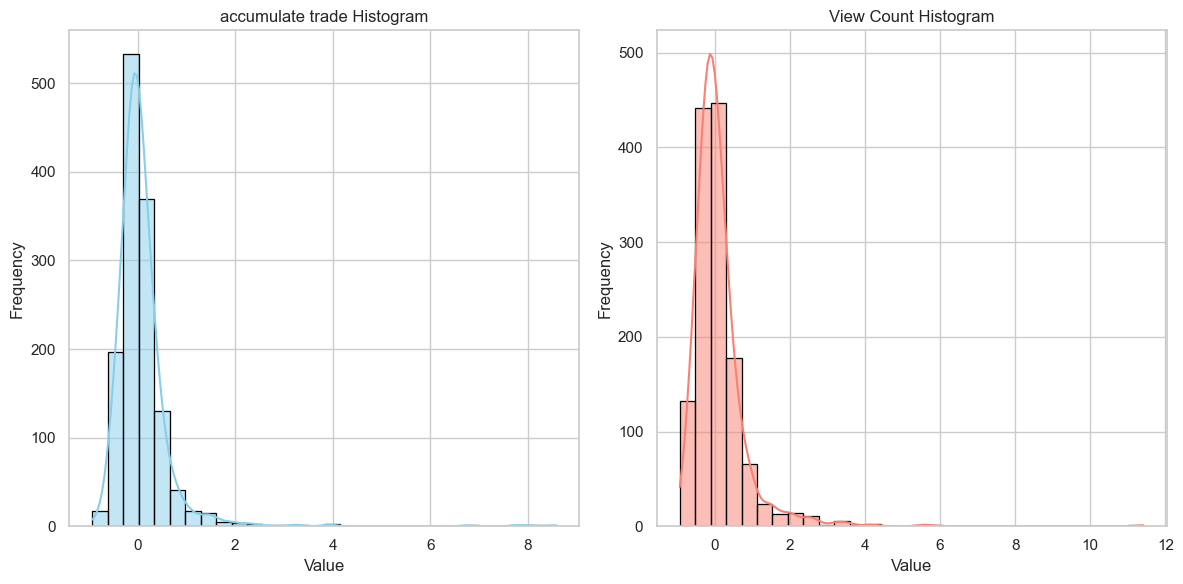

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

series1 = OHLCV_BYN_CNS_SUM_QTY_df
series2 = Day_VW_CNT_df

# 시각화 스타일 설정
sns.set(style='whitegrid')

# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 첫 번째 히스토그램
plt.subplot(1, 2, 1)
sns.histplot(series1, bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('accumulate trade Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 두 번째 히스토그램
plt.subplot(1, 2, 2)
sns.histplot(series2, bins=30, kde=True, color='salmon', edgecolor='black')
plt.title('View Count Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [20]:
t_test(Day_VW_CNT_df,OHLCV_BYN_CNS_SUM_QTY_df)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     14.39
Date:                Fri, 08 Nov 2024   Prob (F-statistic):           0.000155
Time:                        15:39:18   Log-Likelihood:                -1249.4
No. Observations:                1339   AIC:                             2503.
Df Residuals:                    1337   BIC:                             2513.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0723      0.017      4.259      0.0

소비자들이 많이 조회한 종목과 거래량은 통계적으로 유의미한 관계가 존재한다. 

즉 테마라는 것이 소비자들을 유인하기 충분하다는 것이다. 

그렇다면 많이 조회한 종목과 수익률은 관계가 존재할까?

### 조회수와 수익률이 관계가 있을까?

In [21]:
Day_VW_CNT_df = DAY_Data[DAY_Data['TCK_IEM_CD'].isin(divi_etf)].pivot(index='BSE_DT',columns='TCK_IEM_CD',values='VW_TGT_CNT').backfill()
Day_VW_CNT_df.index = pd.to_datetime(Day_VW_CNT_df.index.astype(str), format='%Y%m%d') # 얼마나 봤는가?
# Day_VW_CNT_df = Day_VW_CNT_df.pct_change().dropna()
Day_VW_CNT_df=Day_VW_CNT_df.resample('W').mean()
OHLCV_BF_DD_CMP_IND_RT_df = OHLCV[OHLCV['TCK_IEM_CD'].isin(divi_etf)].pivot(index='BSE_DT',columns='TCK_IEM_CD',values='BF_DD_CMP_IND_RT').backfill()
OHLCV_BF_DD_CMP_IND_RT_df.index = pd.to_datetime(OHLCV_BF_DD_CMP_IND_RT_df.index.astype(str), format='%Y%m%d') #얼마나 사는가?
OHLCV_BF_DD_CMP_IND_RT_df = OHLCV_BF_DD_CMP_IND_RT_df.resample('W').mean() # 단기간에 바로 투자로 적용 안될 수 도 있으니 주간으로 바꿈

In [22]:
columns_with_zero = OHLCV_BF_DD_CMP_IND_RT_df.columns[(OHLCV_BF_DD_CMP_IND_RT_df == 0).any()].tolist()
print("0값이 존재하는 컬럼:", columns_with_zero)

0값이 존재하는 컬럼: ['ESGU', 'IBBQ', 'IWO']


In [23]:
for column in Day_VW_CNT_df.columns:
    if (Day_VW_CNT_df[column] == 0).any():  # 0값이 존재하는 경우
        col_mean = Day_VW_CNT_df[column].replace(0, np.nan).mean()  # 0을 NaN으로 바꾼 후 평균 계산
        Day_VW_CNT_df[column] = Day_VW_CNT_df[column].replace(0, col_mean)

In [24]:
OHLCV_BF_DD_CMP_IND_RT_df=OHLCV_BF_DD_CMP_IND_RT_df.iloc[1:,:].values.flatten() # 이미 수익률임으로 pct처리를 하지 않고 그냥 들고오되 길이를 맞추고자 처음 행 날림
Day_VW_CNT_df=Day_VW_CNT_df.pct_change().dropna().values.flatten()

In [25]:
t_test(Day_VW_CNT_df,OHLCV_BF_DD_CMP_IND_RT_df)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     16.95
Date:                Fri, 08 Nov 2024   Prob (F-statistic):           4.07e-05
Time:                        15:39:28   Log-Likelihood:                -1086.7
No. Observations:                1339   AIC:                             2177.
Df Residuals:                    1337   BIC:                             2188.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0842      0.015      5.605      0.0

소비자들의 관심을 갖는 투자 상품들은 수익률과 전혀 상관이 없다.

### 일간과 격일간의 조회수와 매수량은 어떨까?

In [26]:
Day_VW_CNT_df = DAY_Data[DAY_Data['TCK_IEM_CD'].isin(divi_etf)].pivot(index='BSE_DT',columns='TCK_IEM_CD',values='VW_TGT_CNT').backfill()
Day_VW_CNT_df.index = pd.to_datetime(Day_VW_CNT_df.index.astype(str), format='%Y%m%d') # 얼마나 봤는가?
# Day_VW_CNT_df = Day_VW_CNT_df.pct_change().dropna()
Day_VW_CNT_df=Day_VW_CNT_df.rolling(1).mean().replace(0,Day_VW_CNT_df.mean())
OHLCV_BF_DD_CMP_IND_RT_df = OHLCV[OHLCV['TCK_IEM_CD'].isin(divi_etf)].pivot(index='BSE_DT',columns='TCK_IEM_CD',values='ACL_TRD_QTY').backfill()
OHLCV_BF_DD_CMP_IND_RT_df.index = pd.to_datetime(OHLCV_BF_DD_CMP_IND_RT_df.index.astype(str), format='%Y%m%d') #얼마나 사는가?
OHLCV_BF_DD_CMP_IND_RT_df = OHLCV_BF_DD_CMP_IND_RT_df.rolling(1).mean().replace(0,Day_VW_CNT_df.mean()) 
OHLCV_BF_DD_CMP_IND_RT_df=OHLCV_BF_DD_CMP_IND_RT_df.pct_change().dropna().values.flatten() # 이미 수익률임으로 pct처리를 하지 않고 그냥 들고오되 길이를 맞추고자 처음 행 날림
Day_VW_CNT_df=Day_VW_CNT_df.pct_change().dropna().iloc[:-1,:].values.flatten()

In [27]:
t_test(Day_VW_CNT_df,OHLCV_BF_DD_CMP_IND_RT_df)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8088
Date:                Fri, 08 Nov 2024   Prob (F-statistic):              0.369
Time:                        15:39:32   Log-Likelihood:                -14623.
No. Observations:                6386   AIC:                         2.925e+04
Df Residuals:                    6384   BIC:                         2.926e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1911      0.031      6.250      0.0

하루간의 관계로 보았을때는 p-value가 상당히 높게 나온다. 

In [28]:
Day_VW_CNT_df = DAY_Data[DAY_Data['TCK_IEM_CD'].isin(divi_etf)].pivot(index='BSE_DT',columns='TCK_IEM_CD',values='VW_TGT_CNT').backfill()
Day_VW_CNT_df.index = pd.to_datetime(Day_VW_CNT_df.index.astype(str), format='%Y%m%d') # 얼마나 봤는가?
# Day_VW_CNT_df = Day_VW_CNT_df.pct_change().dropna()
Day_VW_CNT_df=Day_VW_CNT_df.rolling(3).mean().replace(0,Day_VW_CNT_df.mean())
OHLCV_BF_DD_CMP_IND_RT_df = OHLCV[OHLCV['TCK_IEM_CD'].isin(divi_etf)].pivot(index='BSE_DT',columns='TCK_IEM_CD',values='ACL_TRD_QTY').backfill()
OHLCV_BF_DD_CMP_IND_RT_df.index = pd.to_datetime(OHLCV_BF_DD_CMP_IND_RT_df.index.astype(str), format='%Y%m%d') #얼마나 사는가?
OHLCV_BF_DD_CMP_IND_RT_df = OHLCV_BF_DD_CMP_IND_RT_df.rolling(3).mean().replace(0,Day_VW_CNT_df.mean()) 
OHLCV_BF_DD_CMP_IND_RT_df=OHLCV_BF_DD_CMP_IND_RT_df.pct_change().dropna().values.flatten() # 이미 수익률임으로 pct처리를 하지 않고 그냥 들고오되 길이를 맞추고자 처음 행 날림
Day_VW_CNT_df=Day_VW_CNT_df.pct_change().dropna().iloc[:-1,:].values.flatten()

In [29]:
t_test(Day_VW_CNT_df,OHLCV_BF_DD_CMP_IND_RT_df)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     10.62
Date:                Fri, 08 Nov 2024   Prob (F-statistic):            0.00112
Time:                        15:39:35   Log-Likelihood:                -2758.5
No. Observations:                6180   AIC:                             5521.
Df Residuals:                    6178   BIC:                             5535.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0288      0.005      5.943      0.0

특이하게 3일간의 데이터로 보았을 때는 유의미한 관계가 도출되었다. 

즉 투자자들은 관심을 갖는 종목을 단기간에 결정하는 결과로 이루어지는 경향이 있다고 판단 할 수 있다

### ANOVA 검증을 통해 ETF간에 독립성이 존재하는지 확인해본다.

In [30]:
OHLCV_BF_DD_CMP_IND_RT_df = OHLCV[OHLCV['TCK_IEM_CD'].isin(divi_etf)].pivot(index='BSE_DT',columns='TCK_IEM_CD',values='BF_DD_CMP_IND_RT').backfill()
from scipy import stats
def df_ANONVA(cluster_return):
    group_data = [cluster_return[col].dropna() for col in cluster_return.columns]
    group_names = cluster_return.columns.tolist()
    # ANOVA 검정 수행
   
    if len(group_data) != 1:
        f_stat, p_value = stats.f_oneway(*group_data)

        print('ANOVA 검정 결과:')
        print(f'F-통계량: {f_stat:.4f}, p-값: {p_value:.4f}')

        # 결과 해석
        if p_value < 0.05:
            print('그룹 간 평균에 유의한 차이가 있습니다.')
        else:
            print('그룹 간 평균에 유의한 차이가 없습니다.')
    else:
        pass
df_ANONVA(OHLCV_BF_DD_CMP_IND_RT_df) 






ANOVA 검정 결과:
F-통계량: 0.1498, p-값: 1.0000
그룹 간 평균에 유의한 차이가 없습니다.


=> 결론적으로 ETF간에 묶일 여지가 존재한다. 
추가적으로 투자를 잘하는 그룹과 그렇지 않는 그룹을 비교해서 확인 해보았다. 
투자자를 얼만큼 동적으로 하는지 하기위해 자산들의 투자비중간에 var를 계산하였다. 

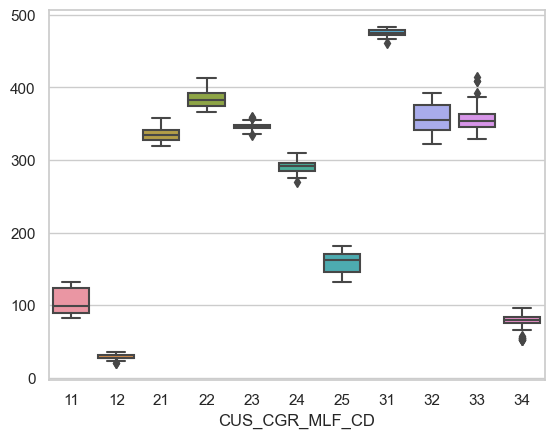

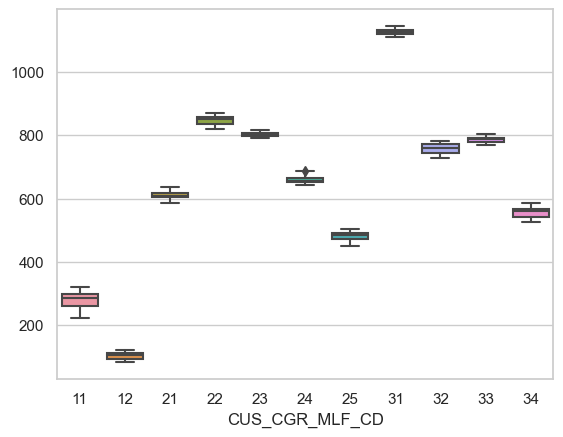

In [31]:
CUSTOMER['BSE_DT'] = pd.to_datetime(CUSTOMER['BSE_DT'], format='%Y%m%d')

# 날짜(BSE_DT)와 중간 분류 코드(CUS_CGR_MLF_CD)로 그룹화
grouped_by_time_and_class = CUSTOMER.groupby(['BSE_DT', 'CUS_CGR_MLF_CD'])

# 계좌수 비율(CUS_CGR_ACT_CNT_RT)의 분산 계산
account_ratio_var_by_time_and_class = grouped_by_time_and_class['CUS_CGR_ACT_CNT_RT'].var().unstack()

# 투자 비율(CUS_CGR_IVS_RT)의 분산 계산
investment_ratio_var_by_time_and_class = grouped_by_time_and_class['CUS_CGR_IVS_RT'].var().unstack()

import seaborn as sns
sns.boxplot(account_ratio_var_by_time_and_class)

plt.show()
sns.boxplot(investment_ratio_var_by_time_and_class)
plt.show()

결론적으로 투자를 잘하는 그룹(11)은 빠르게 투자비중을 변경하는 것을 확인할 수 있다. 

이를통해 시장이 빠르게 변하고 해당 시장에 대응하는 것이 굉장히 중요하다고 판단하였다. 


### 그룹을 잘 묶는 것만으로도 유의미한 결과가 도출될까?
각 ETF를 선택할때 항상 최선의 선택을 하는 것은 굉장히 어렵다.
하지만 최선의 선택이 아니더라도 꽤 괜찮은 선택(상위 20%중 랜덤으로 선택) 하는것은 수익률이 나쁘지 않다. 

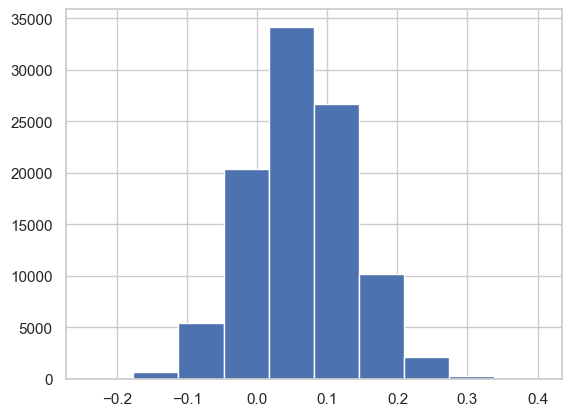

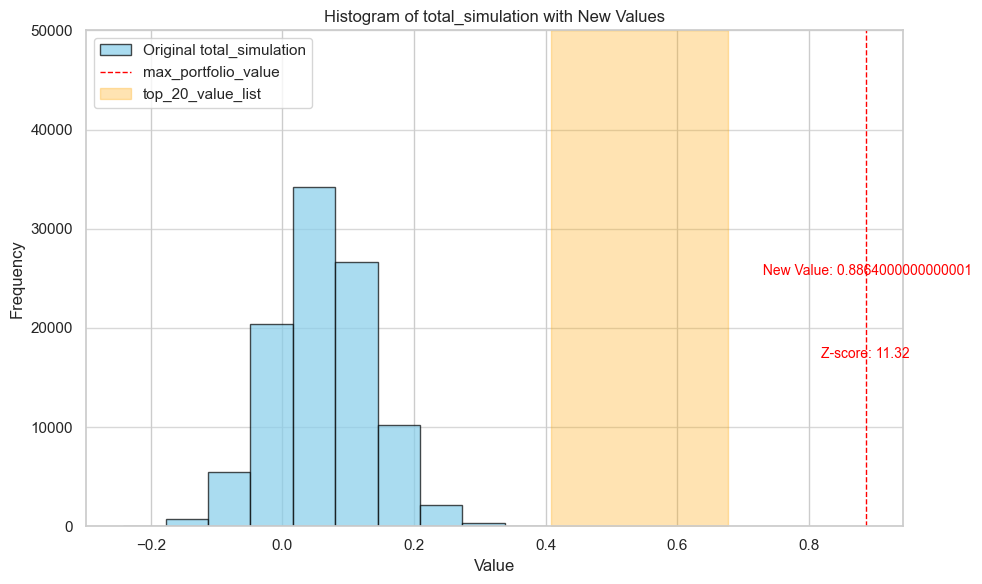

Mean of original total_simulation: 0.06
Standard deviation of original total_simulation: 0.07


In [32]:
etf_return = OHLCV[OHLCV['TCK_IEM_CD'].isin(divi_etf)].pivot(index='BSE_DT',columns='TCK_IEM_CD',values='BF_DD_CMP_IND_RT')*0.01
### 각각의 ETF를 테마라고 보고 테마를 잘 선택 했을때 유믜미 할지
# 인덱스를 문자열로 변환한 후 datetime으로 변환
etf_return.index = pd.to_datetime(etf_return.index.astype(str), format='%Y%m%d')
etf_return_weekly = etf_return.resample('W').sum()
#로그 수익률임으로 sum함
max_portfolio_value = 0
for i in etf_return_weekly.values:
    max_portfolio_value += max(i)
    

top_20_value_list = []
simulation_number_top_20 = 1000
# 각 로우에서 상위 20% 값을 뽑고 랜덤으로 선택
for _ in range(simulation_number_top_20):
    random_samples = []
    for i in range(len(etf_return_weekly)):
        row = etf_return_weekly.iloc[i]  # 각 로우 선택
        threshold = row.quantile(0.90)  # 상위 20%의 기준값 계산
        top_20_percent = row[row >= threshold]  # 상위 20% 값 필터링

        # 상위 20% 값 중 랜덤으로 하나 선택
        if not top_20_percent.empty:
            random_sample = np.random.choice(top_20_percent)
            random_samples.append(random_sample)
    top_20_value = sum(random_samples)
    
    top_20_value_list.append(top_20_value.copy())
    top_20_value = 0
total_simulation = []
simulation_number_all =100000
for i in range(simulation_number_all):
    sum_number = 0
    for i in etf_return_weekly.values:
        sum_number += np.random.choice(i)
    total_simulation.append(sum_number)
plt.hist(total_simulation)
# 새로운 값 추가 (단일 값 또는 리스트)
new_values = [max_portfolio_value,top_20_value_list]  # 예시로 단일 값과 리스트가 혼합됨
names = ["max_portfolio_value",'top_20_value_list']  # 각 값에 대한 이름

# 히스토그램 그리기
plt.figure(figsize=(10, 6))
plt.hist(total_simulation, bins=10, color='skyblue', edgecolor='black', alpha=0.7, label='Original total_simulation')

# 기존 데이터의 평균과 표준편차 계산
mean = np.mean(total_simulation)
std_dev = np.std(total_simulation)

# y축 최대값 설정
plt.ylim(0, len(total_simulation) // 2)  # 데이터 개수에 따라 적절히 조정

# 새로운 값들을 처리
for i, new_value in enumerate(new_values):
    if isinstance(new_value, list):
        # 리스트인 경우, 범위를 색칠 (투명하게)
        min_value = min(new_value)
        max_value = max(new_value)
        
        plt.fill_betweenx(y=[0, len(total_simulation) // 2], x1=min_value, x2=max_value, color='orange', alpha=0.3, label=names[i])
        
    else:
        # 단일 값인 경우, 점선으로 표시
        plt.axvline(new_value, color='red', linestyle='dashed', linewidth=1, label=names[i])
        plt.text(new_value, len(total_simulation) // 4, f' New Value: {new_value}', color='red', ha='center', va='bottom', fontsize=10)

        # 해당 값이 평균에서 얼마나 떨어져 있는지 계산 (z-score)
        z_score = (new_value - mean) / std_dev
        plt.text(new_value, len(total_simulation) // 6, f'Z-score: {z_score:.2f}', color='red', ha='center', va='bottom', fontsize=10)

# 히스토그램 레이블 및 스타일 설정
plt.title('Histogram of total_simulation with New Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

# 평균 및 표준편차 출력
print(f"Mean of original total_simulation: {mean:.2f}")
print(f"Standard deviation of original total_simulation: {std_dev:.2f}")

### 결론

투자자들이 많이 관심을 갖는 상품은 직접적으로 매수로 이어지지만, 이러한 종목들이 항상 높은 수익률과 관련이 있는 것은 아닙니다. 

조회수와 매수량을 비교해보았을 때, 당일에는 큰 관계가 없었으나 다음 날부터 유의미한 상관관계가 나타났습니다. 

이를 통해 투자자들이 예상보다 빠르게 투자 결정을 내리며, 그 결과가 기대에 미치지 못할 수 있음을 알 수 있습니다.

### 투자자들은 현재 뜨고 있는 종목(테마주)에 깊은 관심을 가지지만, 성급한 투자 결정으로 인해 좋은 성과를 내지 못하고 있습니다. 이는 다양한 요인에서 기인하지만, 이번 프로젝트에서는 정보의 양(판단의 양)에 초점을 맞추었습니다.

어떠한 테마가 상승할 때 그 테마를 매수하는 것은 합리적이지만, 때로는 하나의 ETF가 특정 테마를 충분히 대표하지 못할 수 있습니다. 예를 들어, AI 테마가 상승 중일 때, 생성형 AI에 투자하는지 아니면 AI를 활용하는 기업(예: Apple, Microsoft)에 투자하는지에 따라 내부적으로 수익률이 이질적일 수 있습니다. 즉, 하나로 묶여야 할 테마가 분리될 수 있고, 반대로 분리되어야 할 테마가 하나로 묶일 수도 있습니다.

### 따라서 현재 시장 상황에 적합한 테마를 구성하는 것이 사용자들이 투자 판단을 단순화하고, 더 나은 투자 결과를 얻는 데 도움이 될 것이라고 생각했습니다.

복잡한 금융 시장에서 항상 최선의 선택을 하기란 어렵습니다. 그러나 잘 묶인 데이터에서 선택하는 것은 무작위로 선택하는 것보다 훨씬 더 나은 성과를 보입니다.

특히 상위 20%의 종목만을 효과적으로 선별할 수 있다면, 이는 의미 있는 투자로 이어질 것입니다.

기존의 테마주는 시장의 변화를 완벽하게 반영하기 어렵습니다. 테마주는 매우 빠르게 변동하며, 이에 맞춰 새로운 상품이나 그룹을 생성하는 데는 상당한 비용이 소모됩니다.

따라서 우리는 시변하는 주식시장의 특성을 이해하고, 신속하게 새로운 테마를 구성하는 방법을 제시합니다. 이번 프로젝트에서는 특정 테마주가 상승할 것이라는 예측을 제공하지 않습니다. 

대신, 핵심은 각 테마가 명확하게 구분되고, 테마 자체가 잘 선정된다면 그 그룹 내에서 어떤 종목을 선택하더라도 좋은 수익을 올릴 수 있다는 관점에 있습니다.

이를 통해 투자자들이 보다 체계적이고 효율적으로 투자 결정을 내릴 수 있도록 지원하고자 합니다.

추가적으로 각 그룹의 포트폴리오 수익률을 가지고 해당 그룹 맞춤형 테마를 제시할 수 있도록 모델을 만들었습니다. 


----

### 즉, 우리는 그룹 내 자산들의 동질성과 동시성을 최대한 확보하고, 다른 집단과의 배제성을 강화하는 방향으로 모델을 설계할 계획입니다.




## etf를 잘 구별하는 특성이 어떤것이 있을지 확인

1. **BSE_DT** – 거래일자 (여러 테이블에서 사용됨)
2. **IEM_ONG_PR** – 종목시가 (시작 가격)
3. **IEM_HI_PR** – 종목고가 (최고 가격)
4. **IEM_LOW_PR** – 종목저가 (최저 가격)
5. **IEM_END_PR** – 종목종가 (종가)
6. **BF_DD_CMP_IND_PR** – 전일대비증감가격 (전일 종가 대비 변화)
7. **BF_DD_CMP_IND_RT** – 전일대비증감율 (전일 종가 대비 비율 변화)
8. **ACL_TRD_QTY** – 누적거래수량 (총 거래된 수량)
9. **TRD_CST** – 거래대금 (거래된 총 금액)
10. **SLL_CNS_SUM_QTY** – 매도체결합계수량 (매도된 수량)
11. **BYN_CNS_SUM_QTY** – 매수체결합계수량 (매수된 수량)
12. **SBY_BSE_XCG_RT** – 환율 (해외 거래시 적용되는 환율)
13. **TOT_HLD_ACT_CNT** – 총보유계좌수 (ETF를 보유하고 있는 계좌 수)
14. **TOT_HLD_QTY** – 총보유수량 (보유된 총 수량)
15. **TCO_AVG_HLD_QTY** – 당사평균보유수량 (회사의 평균 보유 수량)
16. **TCO_AVG_HLD_WHT_RT** – 당사평균보유비중비율 (평균 보유 비중 비율)
17. **TCO_AVG_EAL_PLS** – 당사평균평가손익 (평균 평가 손익)
18. **TCO_AVG_PHS_UIT_PR** – 당사평균매입단가 (평균 매입 가격)
19. **TCO_AVG_PFT_RT** – 당사평균수익율 (평균 수익률)
20. **TCO_AVG_HLD_TE_DD_CNT** – 당사평균보유기간일수 (평균 보유 기간)
21. **DIST_HNK_PCT10_NMV** – 분포상위10퍼센트수치 (상위 10% 수치)
22. **DIST_HNK_PCT30_NMV** – 분포상위30퍼센트수치 (상위 30% 수치)
23. **DIST_HNK_PCT50_NMV** – 분포상위50퍼센트수치 (상위 50% 수치)
24. **DIST_HNK_PCT70_NMV** – 분포상위70퍼센트수치 (상위 70% 수치)
25. **DIST_HNK_PCT90_NMV** – 분포상위90퍼센트수치 (상위 90% 수치)
26. **BSE_END_PR** – 기준종가 (종가)
27. **LSS_IVO_RT** – 손실투자자비율 (손실 투자자 비율)
28. **PFT_IVO_RT** – 수익투자자비율 (수익 투자자 비율)
29. **IFW_ACT_CNT** – 신규매수계좌수 (신규 매수 계좌 수)
30. **OFW_ACT_CNT** – 전량매도계좌수 (매도 계좌 수)
31. **VW_TGT_CNT** – 종목조회건수 (종목 조회 수)
32. **RGS_TGT_CNT** – 관심종목등록건수 (관심 종목 등록 수)
33. **MM1_TOT_PFT_RT** – 1개월총수익율 (1개월 수익률)
34. **MM3_TOT_PFT_RT** – 3개월총수익율 (3개월 수익률)
35. **YR1_TOT_PFT_RT** – 1년총수익율 (1년 수익률)
36. **ETF_SOR** – ETF점수 (ETF 평가 점수)
37. **ETF_Z_SOR** – ETFZ점수 (ETF Z-Score)
38. **Z_SOR_RNK** – Z점수순위 (Z-Score 순위)
39. **ACL_PFT_RT_Z_SOR** – 누적수익율Z점수 (누적 수익률 Z-Score)
40. **IFO_RT_Z_SOR** – 정보비율Z점수 (정보 비율 Z-Score)
41. **SHPR_Z_SOR** – 샤프지수Z점수 (Sharpe Ratio Z-Score)
42. **CRR_Z_SOR** – 상관관계Z점수 (상관관계 Z-Score)
43. **TRK_ERR_Z_SOR** – 트래킹에러Z점수 (Tracking Error Z-Score)
44. **MXDD_Z_SOR** – 최대낙폭Z점수 (Max Drawdown Z-Score)
45. **VTY_Z_SOR** – 변동성Z점수 (변동성 Z-Score)

### 1. **가격 관련 그룹 (Price-Related)**

- **IEM_ONG_PR** – 종목시가 (시작 가격)
- **IEM_HI_PR** – 종목고가 (최고 가격)
- **IEM_LOW_PR** – 종목저가 (최저 가격)
- **IEM_END_PR** – 종목종가 (종가)
- **BF_DD_CMP_IND_PR** – 전일대비증감가격 (전일 종가 대비 변화)
- **BF_DD_CMP_IND_RT** – 전일대비증감율 (전일 종가 대비 비율 변화)
- **BSE_END_PR** – 기준종가 (종가)

### 2. **거래 관련 그룹 (Trading-Related)**

- **ACL_TRD_QTY** – 누적거래수량 (총 거래된 수량)
- **TRD_CST** – 거래대금 (거래된 총 금액)
- **SLL_CNS_SUM_QTY** – 매도체결합계수량 (매도된 수량)
- **BYN_CNS_SUM_QTY** – 매수체결합계수량 (매수된 수량)

### 3. **계좌 및 보유 관련 그룹 (Account & Holdings)**

- **TOT_HLD_ACT_CNT** – 총보유계좌수 (ETF를 보유하고 있는 계좌 수)
- **TOT_HLD_QTY** – 총보유수량 (보유된 총 수량)
- **TCO_AVG_HLD_QTY** – 당사평균보유수량 (회사의 평균 보유 수량)
- **TCO_AVG_HLD_WHT_RT** – 당사평균보유비중비율 (평균 보유 비중 비율)
- **TCO_AVG_HLD_TE_DD_CNT** – 당사평균보유기간일수 (평균 보유 기간)

### 4. **수익 및 손익 관련 그룹 (Profit & Loss)**

- **TCO_AVG_EAL_PLS** – 당사평균평가손익 (평균 평가 손익)
- **TCO_AVG_PHS_UIT_PR** – 당사평균매입단가 (평균 매입 가격)
- **TCO_AVG_PFT_RT** – 당사평균수익율 (평균 수익률)
- **MM1_TOT_PFT_RT** – 1개월총수익율 (1개월 수익률)
- **MM3_TOT_PFT_RT** – 3개월총수익율 (3개월 수익률)
- **YR1_TOT_PFT_RT** – 1년총수익율 (1년 수익률)
- **ACL_PFT_RT_Z_SOR** – 누적수익율Z점수 (누적 수익률 Z-Score)

### 5. **투자자 관련 그룹 (Investor-Related)**

- **LSS_IVO_RT** – 손실투자자비율 (손실 투자자 비율)
- **PFT_IVO_RT** – 수익투자자비율 (수익 투자자 비율)
- **IFW_ACT_CNT** – 신규매수계좌수 (신규 매수 계좌 수)
- **OFW_ACT_CNT** – 전량매도계좌수 (매도 계좌 수)

### 6. **순위 및 점수 관련 그룹 (Ranking & Scores)**

- **ETF_SOR** – ETF점수 (ETF 평가 점수)
- **ETF_Z_SOR** – ETFZ점수 (ETF Z-Score)
- **Z_SOR_RNK** – Z점수순위 (Z-Score 순위)
- **IFO_RT_Z_SOR** – 정보비율Z점수 (정보 비율 Z-Score)
- **SHPR_Z_SOR** – 샤프지수Z점수 (Sharpe Ratio Z-Score)
- **CRR_Z_SOR** – 상관관계Z점수 (상관관계 Z-Score)
- **TRK_ERR_Z_SOR** – 트래킹에러Z점수 (Tracking Error Z-Score)
- **MXDD_Z_SOR** – 최대낙폭Z점수 (Max Drawdown Z-Score)
- **VTY_Z_SOR** – 변동성Z점수 (변동성 Z-Score)

### 7. **분포 및 지표 관련 그룹 (Distribution & Indicators)**

- **DIST_HNK_PCT10_NMV** – 분포상위10퍼센트수치 (상위 10% 수치)
- **DIST_HNK_PCT30_NMV** – 분포상위30퍼센트수치 (상위 30% 수치)
- **DIST_HNK_PCT50_NMV** – 분포상위50퍼센트수치 (상위 50% 수치)
- **DIST_HNK_PCT70_NMV** – 분포상위70퍼센트수치 (상위 70% 수치)
- **DIST_HNK_PCT90_NMV** – 분포상위90퍼센트수치 (상위 90% 수치)

### 8. **기타 (Miscellaneous)**

- **SBY_BSE_XCG_RT** – 환율 (해외 거래시 적용되는 환율)
- **VW_TGT_CNT** – 종목조회건수 (종목 조회 수)
- **RGS_TGT_CNT** – 관심종목등록건수 (관심 종목 등록 수)

In [136]:
# 각각의 특성별로 dict 데이터 생성

grouped_features_dict = {
    "Price": [
        'IEM_ONG_PR', 'IEM_HI_PR', 'IEM_LOW_PR', 'IEM_END_PR',
        'BF_DD_CMP_IND_PR', 'BF_DD_CMP_IND_RT', 'BSE_END_PR'
    ],
    "Trading": [
        'ACL_TRD_QTY', 'TRD_CST', 'SLL_CNS_SUM_QTY', 'BYN_CNS_SUM_QTY'
    ],
    "Account": [
        'TOT_HLD_ACT_CNT', 'TOT_HLD_QTY', 'TCO_AVG_HLD_QTY',
        'TCO_AVG_HLD_WHT_RT', 'TCO_AVG_HLD_TE_DD_CNT'
    ],
    "Profit": [
        'TCO_AVG_EAL_PLS', 'TCO_AVG_PHS_UIT_PR', 'TCO_AVG_PFT_RT',
        'MM1_TOT_PFT_RT', 'MM3_TOT_PFT_RT', 'YR1_TOT_PFT_RT',
        'ACL_PFT_RT_Z_SOR'
    ],
    "Investor": [
        'LSS_IVO_RT', 'PFT_IVO_RT', 'IFW_ACT_CNT', 'OFW_ACT_CNT'
    ],
    "Scores": [
        'ETF_SOR', 'ETF_Z_SOR', 'Z_SOR_RNK', 'IFO_RT_Z_SOR',
        'SHPR_Z_SOR', 'CRR_Z_SOR', 'TRK_ERR_Z_SOR', 'MXDD_Z_SOR',
        'VTY_Z_SOR'
    ],
    "Distribution": [
        'DIST_HNK_PCT10_NMV', 'DIST_HNK_PCT30_NMV', 'DIST_HNK_PCT50_NMV',
        'DIST_HNK_PCT70_NMV', 'DIST_HNK_PCT90_NMV'
    ],
    "else": [
        'SBY_BSE_XCG_RT', 'VW_TGT_CNT', 'RGS_TGT_CNT'
    ]
}

In [137]:
# 같은 특성이지만 다른 열 이름으로 되어있는거 통합
OHLCV_1 = OHLCV.rename(columns={'TCK_IEM_CD': 'ETF_IEM_CD'})
DAY_Data_1 = DAY_Data.rename(columns={'TCK_IEM_CD': 'ETF_IEM_CD'})

# 각각의 파일에서 중복되는 etf만 추출
filtered_OHLCV_1 = OHLCV_1[OHLCV_1['ETF_IEM_CD'].isin(divi_etf)]
filtered_score = SCORE[SCORE['ETF_IEM_CD'].isin(divi_etf)]
filtered_day_data_1 = DAY_Data_1[DAY_Data_1['ETF_IEM_CD'].isin(divi_etf)]

# 추출한 etf끼리 병합 병합 기준은 날짜와 etf이름
merge_score_day = pd.merge(filtered_score, filtered_day_data_1, on=['BSE_DT', 'ETF_IEM_CD'], how='inner')
merge_date_df = pd.merge(merge_score_day, filtered_OHLCV_1, on=['BSE_DT', 'ETF_IEM_CD'], how='inner')

merge_date_df.head()

BSE_DT ETF_IEM_CD  MM1_TOT_PFT_RT  MM3_TOT_PFT_RT  YR1_TOT_PFT_RT  \
0  20240717       CIBR          6.1196          8.8162         28.1019   
1  20240611       CIBR         -1.7525         -6.9114         24.8726   
2  20240711       CIBR          5.7728          1.4921         28.2238   
3  20240821       CIBR          4.4013          4.8979         33.8371   
4  20240709       CIBR          7.1225          3.3159         27.7462   

     ETF_SOR  ETF_Z_SOR  Z_SOR_RNK  ACL_PFT_RT_Z_SOR  IFO_RT_Z_SOR  ...  \
0  48.240248  65.957447        385         77.659574     81.648936  ...   
1  46.758123  58.483755        461         73.285199     75.902527  ...   
2  48.550222  66.488889        378         77.511111     80.888889  ...   
3  52.891399  80.973067        220         86.794092     87.489140  ...   
4  48.783111  65.422222        390         78.844444     80.355556  ...   

   IEM_HI_PR  IEM_LOW_PR  IEM_END_PR  BF_DD_CMP_IND_PR  BF_DD_CMP_IND_RT  \
0     57.695       56.94       57.16             -1.27             -2.17   
1     54.740       53.97       54.64              0.01              0.02   
2     57.850       56.84       57.08              0.06              0.11   
3     59.210       58.70       59.20              0.19              0.32   
4     57.730       56.62       56.86             -0.63             -1.10   

   ACL_TRD_QTY     TRD_CST  SLL_CNS_SUM_QTY  BYN_CNS_SUM_QTY  SBY_BSE_XCG_RT  
0     518819.0  29863337.0              0.0              0.0          1386.0  
1     418842.0  22885527.0         215883.0         202959.0          1377.9  
2     606786.0  34701727.0         684928.0         828618.0          1385.6  
3     462862.0  27284002.0         677107.0        3598526.0          1332.0  
4     525555.0  29918479.0         804432.0         498629.0          1379.4  

[5 rows x 46 columns]

In [138]:
import numpy as np
from fastdtw import fastdtw
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

linked_list = []

for k, v in grouped_features_dict.items():
    numeric_cols = v
    df_numeric = merge_date_df[numeric_cols].dropna()

    # 데이터 스케일링
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_numeric)

    # DTW 거리를 계산할 때 각 샘플 간의 거리를 계산
    num_samples = df_scaled.shape[0]
    dist_matrix = np.zeros((num_samples, num_samples))

    for i in range(num_samples):
        for j in range(i + 1, num_samples):
            # fastdtw로 두 시계열 간의 거리 계산
            distance, _ = fastdtw(df_scaled[i], df_scaled[j])
            dist_matrix[i, j] = distance
            dist_matrix[j, i] = distance

    # 거리 행렬을 기반으로 계층적 군집화를 수행
    linked = linkage(squareform(dist_matrix), method='ward')
    linked_list.append(linked)


# 이후 클러스터링 작업은 동일하게 진행
new_merge_date_df = merge_date_df.copy()

total_case = []

for linked in linked_list:
    now_case = []

    # 클러스터 수를 결정하여 레이블 지정
    clusters = fcluster(linked, 20, criterion='maxclust')

    # 클러스터 결과를 원래 데이터프레임에 추가
    new_merge_date_df['Cluster'] = clusters

    # 클러스터별로 각 ETF_IEM_CD 값을 추출
    df_clustered_etf = new_merge_date_df.groupby('Cluster')['ETF_IEM_CD'].apply(lambda x: list(set(x)))

    # 결과 저장
    for cases in df_clustered_etf:
        now_case.append(len(cases))
    total_case.append(now_case)

# 결과 확인
total_case

KeyboardInterrupt: 

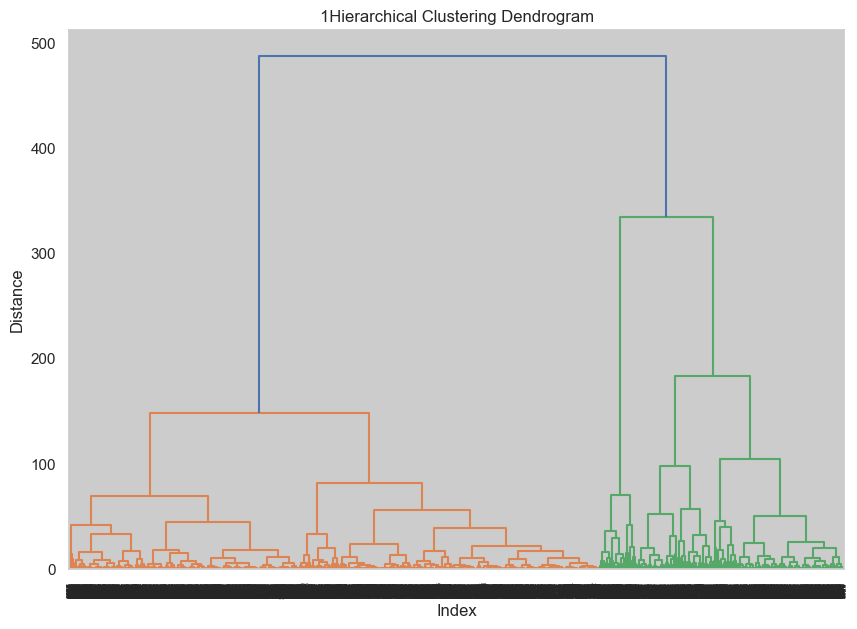

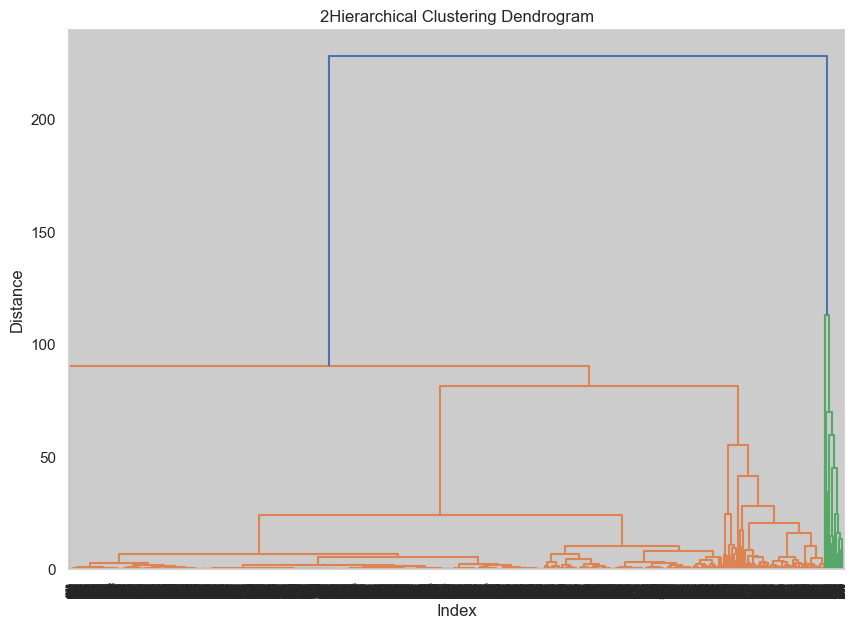

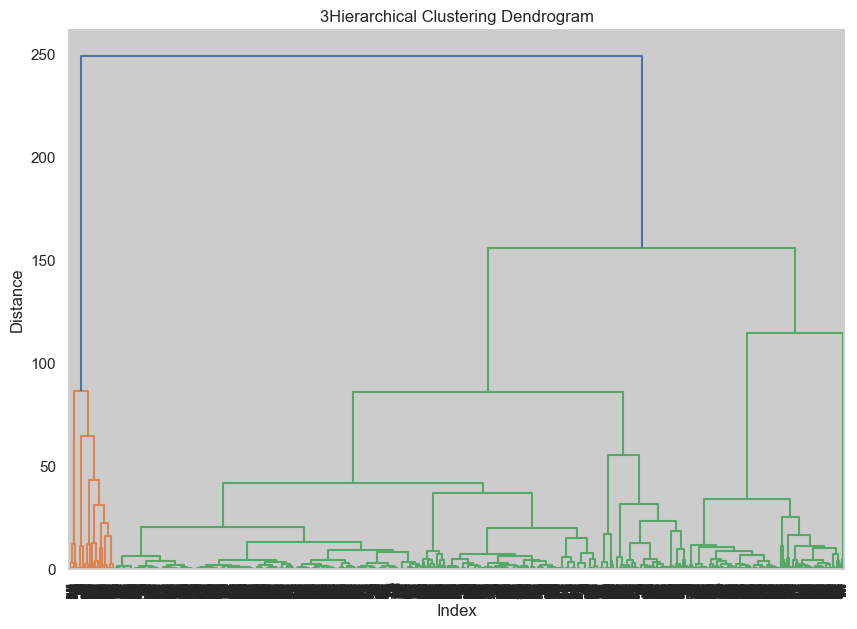

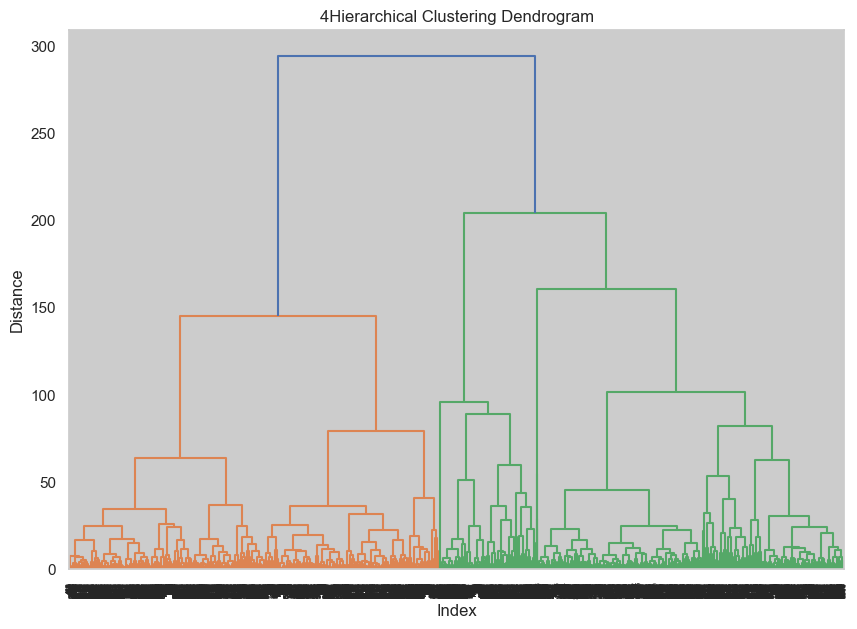

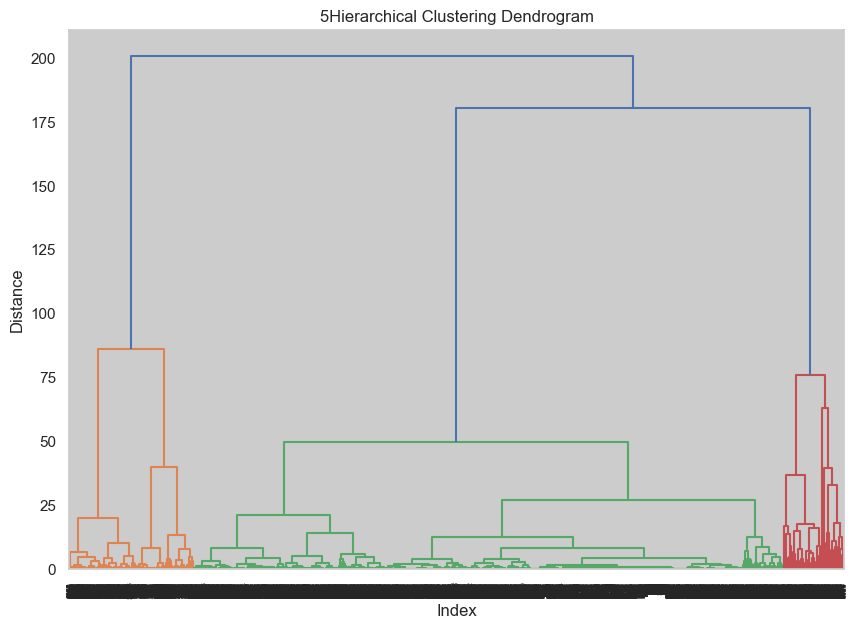

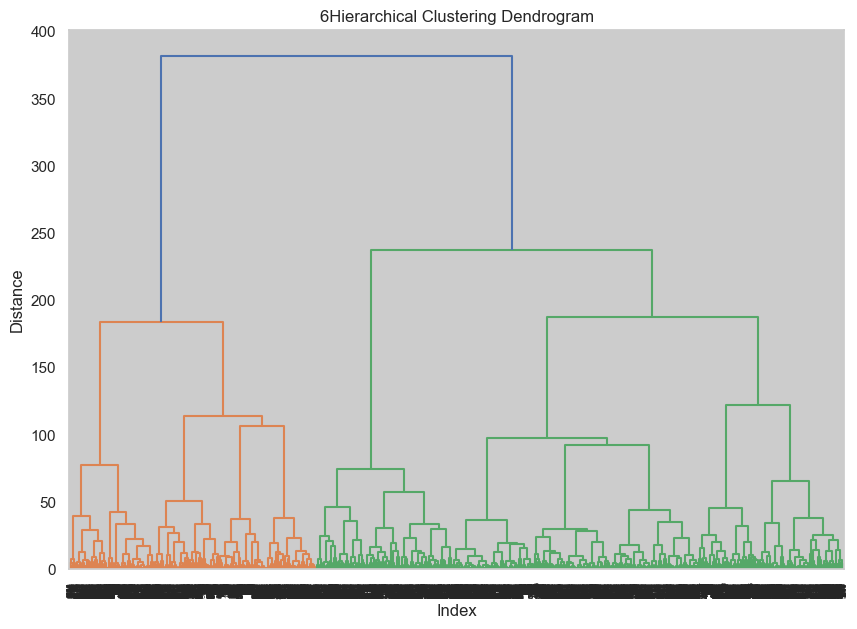

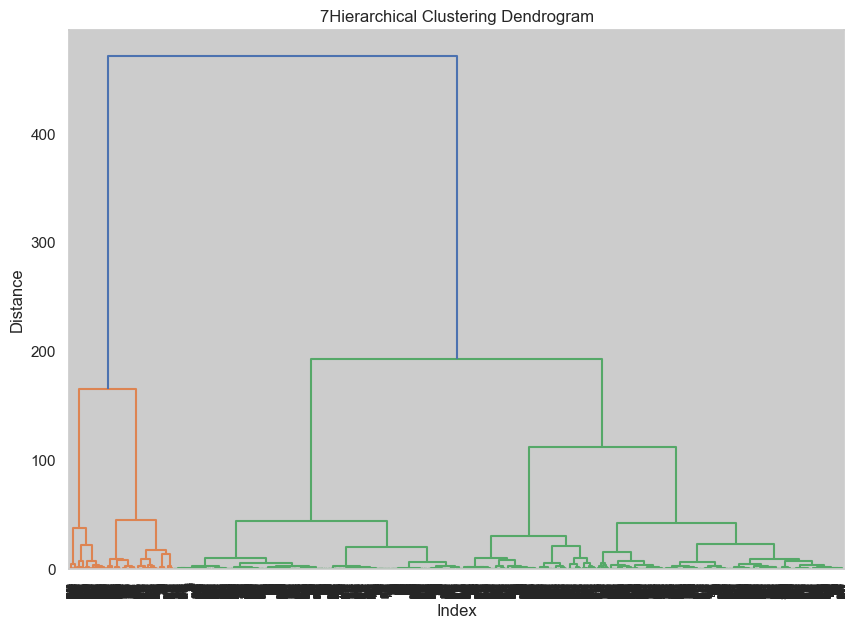

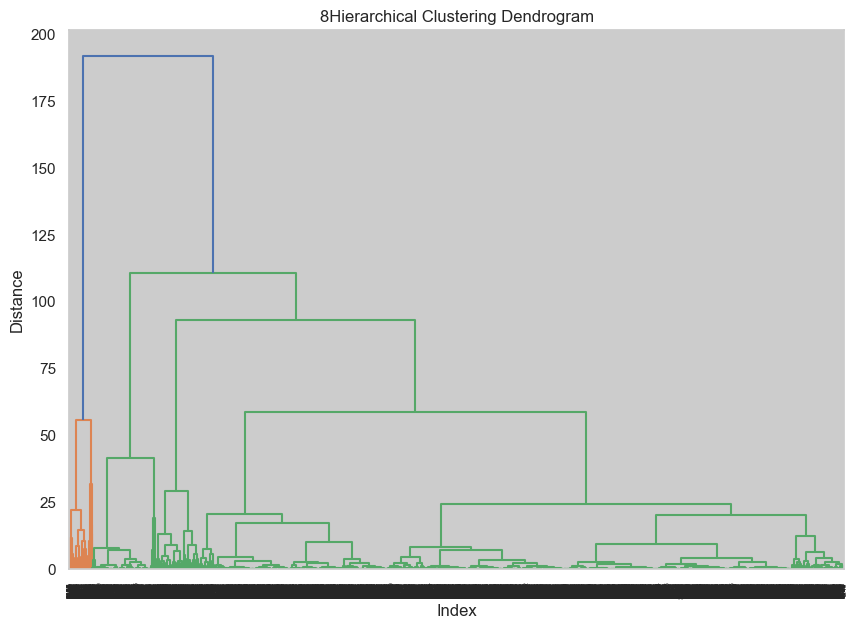

In [ ]:
for i,linked in enumerate(linked_list):
    # 덴드로그램 시각화
    plt.figure(figsize=(10, 7))
    dendrogram(linked, orientation='top', distance_sort='ascending', show_leaf_counts=False)
    plt.title(f"{i+1}Hierarchical Clustering Dendrogram")
    plt.xlabel("Index")
    plt.xticks(rotation = 90)
    plt.ylabel("Distance")
    plt.show()

In [ ]:
total_case = []

for linked in linked_list:
    now_case = []

    # 클러스터 수를 결정하여 레이블 지정
    clusters = fcluster(linked, 20, criterion='maxclust')

    # 클러스터 결과를 원래 데이터프레임에 추가
    new_merge_date_df['Cluster'] = clusters

    # 클러스터별로 각 ETF_IEM_CD 값을 추출
    df_clustered_etf = new_merge_date_df.groupby('Cluster')['ETF_IEM_CD'].apply(lambda x: list(set(x)))

    # 결과 저장
    for cases in df_clustered_etf:
        now_case.append(len(cases))
    total_case.append(now_case)

# 결과 확인
total_case

[[11, 41, 21, 24, 59, 13, 28, 28, 5, 5, 5, 10, 9, 5, 5, 4, 26, 9, 24, 22],
 [83, 71, 5, 13, 4, 23, 21, 34, 1, 1, 1, 3, 1, 2, 2, 3, 1, 4, 3, 5],
 [1, 1, 1, 1, 2, 2, 18, 51, 93, 31, 7, 2, 2, 14, 5, 62, 3, 43, 1, 1],
 [23, 26, 30, 4, 2, 1, 5, 3, 8, 1, 5, 2, 2, 22, 35, 17, 9, 12, 8, 26],
 [46, 32, 7, 21, 79, 68, 85, 28, 2, 9, 8, 7, 10, 8, 4, 5, 6, 5, 7, 8],
 [2, 11, 1, 8, 9, 9, 11, 9, 9, 8, 13, 16, 19, 25, 13, 11, 16, 12, 8, 15],
 [1, 1, 3, 4, 3, 1, 1, 9, 14, 9, 10, 5, 7, 4, 2, 2, 2, 9, 10, 17],
 [5, 6, 6, 5, 1, 1, 1, 96, 6, 4, 7, 18, 8, 12, 23, 93, 94, 94, 91, 45]]

### 가장 잘 나뉘어지는 6번째 클러스터링에 사용된 아래의 특성들을 사용한다

### 4. **수익 및 손익 관련 그룹 (Profit & Loss)**

- **TCO_AVG_EAL_PLS** – 당사평균평가손익 (평균 평가 손익)
- **TCO_AVG_PHS_UIT_PR** – 당사평균매입단가 (평균 매입 가격)
- **TCO_AVG_PFT_RT** – 당사평균수익율 (평균 수익률)
- **MM1_TOT_PFT_RT** – 1개월총수익율 (1개월 수익률)
- **MM3_TOT_PFT_RT** – 3개월총수익율 (3개월 수익률)
- **YR1_TOT_PFT_RT** – 1년총수익율 (1년 수익률)
- **ACL_PFT_RT_Z_SOR** – 누적수익율Z점수 (누적 수익률 Z-Score)

### 6. **순위 및 점수 관련 그룹 (Ranking & Scores)**

- **ETF_SOR** – ETF점수 (ETF 평가 점수)
- **ETF_Z_SOR** – ETFZ점수 (ETF Z-Score)
- **Z_SOR_RNK** – Z점수순위 (Z-Score 순위)
- **IFO_RT_Z_SOR** – 정보비율Z점수 (정보 비율 Z-Score)
- **SHPR_Z_SOR** – 샤프지수Z점수 (Sharpe Ratio Z-Score)
- **CRR_Z_SOR** – 상관관계Z점수 (상관관계 Z-Score)
- **TRK_ERR_Z_SOR** – 트래킹에러Z점수 (Tracking Error Z-Score)
- **MXDD_Z_SOR** – 최대낙폭Z점수 (Max Drawdown Z-Score)
- **VTY_Z_SOR** – 변동성Z점수 (변동성 Z-Score)

### 7. **분포 및 지표 관련 그룹 (Distribution & Indicators)**

- **DIST_HNK_PCT10_NMV** – 분포상위10퍼센트수치 (상위 10% 수치)
- **DIST_HNK_PCT30_NMV** – 분포상위30퍼센트수치 (상위 30% 수치)
- **DIST_HNK_PCT50_NMV** – 분포상위50퍼센트수치 (상위 50% 수치)
- **DIST_HNK_PCT70_NMV** – 분포상위70퍼센트수치 (상위 70% 수치)
- **DIST_HNK_PCT90_NMV** – 분포상위90퍼센트수치 (상위 90% 수치)

## XGboost로 관련 특성중 GNN모델에 사용할 특성 정하기

### 1. 전체적인 시장의 테마를 보여준다  => XGboost의 타겟라벨은 각각 자산의 수익률
### 2. 개인화된 시장의 테마를 보겠다. => XGboost의 타겟라벨은 개인의 포트폴리오 수익률

In [33]:
grouped_features_dict = {
    "Profit": [
        'TCO_AVG_EAL_PLS', 'TCO_AVG_PHS_UIT_PR', 'TCO_AVG_PFT_RT',
        'MM1_TOT_PFT_RT', 'MM3_TOT_PFT_RT', 'YR1_TOT_PFT_RT',
        'ACL_PFT_RT_Z_SOR'
    ],
    "Scores": [
        'ETF_SOR', 'ETF_Z_SOR', 'Z_SOR_RNK', 'IFO_RT_Z_SOR',
        'SHPR_Z_SOR', 'CRR_Z_SOR', 'TRK_ERR_Z_SOR', 'MXDD_Z_SOR',
        'VTY_Z_SOR'
    ],
    "Distribution": [
        'DIST_HNK_PCT10_NMV', 'DIST_HNK_PCT30_NMV', 'DIST_HNK_PCT50_NMV',
        'DIST_HNK_PCT70_NMV', 'DIST_HNK_PCT90_NMV'
    ]
}

아래 코드는 그룹을 하나의 포트폴리오라고 생각하고 수익률을 계산한 코드이다.

In [34]:
CUSTOMER['BSE_DT'] = pd.to_datetime(CUSTOMER['BSE_DT'], format='%Y%m%d')

OHLCV['BSE_DT'] = pd.to_datetime(OHLCV['BSE_DT'], format='%Y%m%d')
# 날짜와 중간 분류 코드, 종목별로 그룹화하여 시계열 분석
grouped_by_time_and_class = CUSTOMER.groupby(['BSE_DT', 'CUS_CGR_MLF_CD', 'TCK_IEM_CD'])

# 계좌 비율과 투자 비율의 시계열 분석 (날짜별로 그룹화)
account_ratio_by_time = grouped_by_time_and_class['CUS_CGR_ACT_CNT_RT'].sum().unstack(level='CUS_CGR_MLF_CD')
investment_ratio_by_time = grouped_by_time_and_class['CUS_CGR_IVS_RT'].sum().unstack(level='CUS_CGR_MLF_CD')
investment_ratio_by_time_Custom_fillna_B1 = investment_ratio_by_time[[11,12]].fillna(0)

DAY_Data['BSE_DT'] = pd.to_datetime(DAY_Data['BSE_DT'], format='%Y%m%d')

# 날짜와 중간 분류 코드, 종목별로 그룹화하여 시계열 분석
grouped_by_time_and_class_DD = DAY_Data.groupby(['BSE_DT', 'TCK_IEM_CD', 'TOT_HLD_QTY'])
day_data_allocation = DAY_Data.sort_values('BSE_DT')[['BSE_DT', 'TCK_IEM_CD', 'TOT_HLD_QTY','BSE_END_PR']]
merged_data_B1 = pd.merge(investment_ratio_by_time_Custom_fillna_B1, day_data_allocation, how='inner', on=['BSE_DT', 'TCK_IEM_CD'])
merged_data_B1 = pd.merge(investment_ratio_by_time_Custom_fillna_B1, day_data_allocation, how='inner', on=['BSE_DT', 'TCK_IEM_CD'])

# 각 그룹별로 투자 금액 계산
merged_data_B1['Group_11_investment'] = merged_data_B1['TOT_HLD_QTY'] * merged_data_B1[11]*0.01 * merged_data_B1['BSE_END_PR']
merged_data_B1['Group_12_investment'] = merged_data_B1['TOT_HLD_QTY'] * merged_data_B1[12]*0.01 * merged_data_B1['BSE_END_PR']


# 최종 결과
group_investment_by_date = merged_data_B1.groupby(['BSE_DT', 'TCK_IEM_CD'])[['Group_11_investment', 'Group_12_investment']].sum()

print(group_investment_by_date)
# 그룹 11과 그룹 12의 투자 금액을 계산


# 날짜별로 각 그룹의 총 투자 금액을 계산
daily_group_11_investment = merged_data_B1.groupby('BSE_DT')['Group_11_investment'].sum().reset_index()
daily_group_12_investment = merged_data_B1.groupby('BSE_DT')['Group_12_investment'].sum().reset_index()


# 원본 데이터에 날짜별 총 투자 금액을 병합
merged_data_B1 = pd.merge(merged_data_B1, daily_group_11_investment, on='BSE_DT', suffixes=('', '_total_11'))
merged_data_B1 = pd.merge(merged_data_B1, daily_group_12_investment, on='BSE_DT', suffixes=('', '_total_12'))



# 각 자산의 날짜별 투자 비중 계산 (날짜별 총 투자 금액을 사용하여 비중을 재계산)
merged_data_B1['Group_11_ratio'] = merged_data_B1['Group_11_investment'] / merged_data_B1['Group_11_investment_total_11']
merged_data_B1['Group_12_ratio'] = merged_data_B1['Group_12_investment'] / merged_data_B1['Group_12_investment_total_12']


# 2. 종가 증감율을 이용한 수익률 계산
# OHLCV에서 날짜와 종목 코드를 기준으로 데이터 병합
merged_data_B1 = pd.merge(merged_data_B1, OHLCV[['BSE_DT', 'TCK_IEM_CD', 'BF_DD_CMP_IND_RT']], how='inner', on=['BSE_DT', 'TCK_IEM_CD'])

# 각 그룹의 수익률 계산 (자산의 수익률에 비중을 곱해 포트폴리오 수익률 구함)
merged_data_B1['Group_11_return'] = merged_data_B1['Group_11_ratio'] * merged_data_B1['BF_DD_CMP_IND_RT']
merged_data_B1['Group_12_return'] = merged_data_B1['Group_12_ratio'] * merged_data_B1['BF_DD_CMP_IND_RT']

# 날짜별 포트폴리오 수익률 계산
portfolio_return_B1 = merged_data_B1.groupby('BSE_DT')[['Group_11_return', 'Group_12_return']].sum()

# 최종 결과 출력


                       Group_11_investment  Group_12_investment
BSE_DT     TCK_IEM_CD                                          
2024-05-28 A                  4.112642e+05         3.581451e+08
           AA                 2.029725e+07         4.736612e+08
           AADI               2.763559e+04         4.986987e+06
           AAL                1.075592e+08         4.103843e+09
           AAME               6.465876e+05         2.901748e+07
...                                    ...                  ...
2024-08-26 ZTS                4.849310e+05         2.775718e+08
           ZUO                1.206226e+04         6.247545e+06
           ZURA               0.000000e+00         1.987243e+08
           ZVRA               1.972473e+06         1.349763e+08
           ZYME               3.006982e+06         4.983608e+07

[114612 rows x 2 columns]


In [35]:
merge_date_df['BSE_DT'] = pd.to_datetime(merge_date_df['BSE_DT'], format='%Y%m%d')

NameError: name 'merge_date_df' is not defined

In [36]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

merge_date_df_1 = merge_date_df[["BSE_DT"]+grouped_features_dict["Profit"] + grouped_features_dict["Scores"] + grouped_features_dict["Distribution"]]

merged_df = pd.merge(merge_date_df_1, portfolio_return_B1, on='BSE_DT')


X = merged_df.iloc[:,1:-2]  # BSE_DT 제외
y_group_11 = merged_df['Group_11_return']  # Group 11의 수익률
y_group_12 = merged_df['Group_12_return']  # Group 12의 수익률

# 데이터셋을 학습용과 테스트용으로 분할 (Group 11과 Group 12)
X_train_11, X_test_11, y_train_11, y_test_11 = train_test_split(X, y_group_11, test_size=0.2, random_state=42)
X_train_12, X_test_12, y_train_12, y_test_12 = train_test_split(X, y_group_12, test_size=0.2, random_state=42)

# XGBoost 모델 정의 및 학습 (Group 11)
model_11 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05, max_depth=6)
model_11.fit(X_train_11, y_train_11)

# XGBoost 모델 정의 및 학습 (Group 12)
model_12 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05, max_depth=6)
model_12.fit(X_train_12, y_train_12)

# Feature 중요도 추출 (Group 11)
importance_11 = model_11.get_booster().get_score(importance_type='weight')
importance_df_11 = pd.DataFrame({
    'Feature': list(importance_11.keys()),
    'Importance': list(importance_11.values())
})

# Feature 중요도 추출 (Group 12)
importance_12 = model_12.get_booster().get_score(importance_type='weight')
importance_df_12 = pd.DataFrame({
    'Feature': list(importance_12.keys()),
    'Importance': list(importance_12.values())
})

# 중요도 기준 상위 5개 특성 추출 (Group 11)
top_5_features_11 = importance_df_11.nlargest(5, 'Importance')

# 중요도 기준 상위 5개 특성 추출 (Group 12)
top_5_features_12 = importance_df_12.nlargest(5, 'Importance')

# 시각화
plt.figure(figsize=(14, 10))

# 상위 5개 특성 시각화 (Group 11)
plt.subplot(2, 1, 1)  # 2행 1열의 첫 번째 플롯
sns.barplot(x='Importance', y='Feature', data=top_5_features_11, palette='Blues_d')
plt.title('Top 5 Feature Importance for Group 11', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# 상위 5개 특성 시각화 (Group 12)
plt.subplot(2, 1, 2)  # 2행 1열의 두 번째 플롯
sns.barplot(x='Importance', y='Feature', data=top_5_features_12, palette='Greens_d')
plt.title('Top 5 Feature Importance for Group 12', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)

plt.tight_layout()
plt.show()

# 상위 5개 특성 출력
print("\nTop 5 Important Features for Group 11:")
print(top_5_features_11)

print("\nTop 5 Important Features for Group 12:")
print(top_5_features_12)

NameError: name 'merge_date_df' is not defined

### XGboost를 사용해 피쳐들의 중요도를 뽑고 상위 중요도에 존재하는 피쳐들을 최종적으로 노드의 특성으로 사용한다
11그룹에 알맞는 테마를 만들기 위해 xgboost로 뽑은 특성을 노드에 넣는다.

In [7]:
top_5_features_11

NameError: name 'top_5_features_11' is not defined

In [145]:
top_5_features_11['Feature'].values

array(['TCO_AVG_EAL_PLS', 'MM3_TOT_PFT_RT', 'MM1_TOT_PFT_RT',
       'YR1_TOT_PFT_RT', 'ACL_PFT_RT_Z_SOR'], dtype=object)

In [37]:
feature_list = ['TCO_AVG_EAL_PLS','TCO_AVG_PFT_RT','ACL_PFT_RT_Z_SOR','DIST_HNK_PCT10_NMV']

In [38]:
import pandas as pd
import numpy as np
from functools import reduce

# 데이터프레임 매핑 설정
tables = {
    'DIVIDEND': DIVIDEND,
    'SCORE': SCORE,
    'ETF_Holding': ETF_Holding,
    'CUSTOMER': CUSTOMER,
    'INCOME_Outcome_Flow': INCOME_Outcome_Flow,
    'DAY_Data': DAY_Data,
    'STOCK_Explane': STOCK_Explane,
    'OHLCV': OHLCV
}

# 병합된 데이터프레임을 생성하는 함수
def generate_merged_df(feature_list):
    reshaped_dfs = []
    
    for feature_name in feature_list:
        found = False

        # 각 테이블에서 컬럼을 찾아 데이터프레임을 구성
        for table_name, df in tables.items():
            if feature_name in df.columns:
                found = True
                # ETF 식별자 컬럼 찾기
                etf_id_col = 'ETF_IEM_CD' if 'ETF_IEM_CD' in df.columns else 'TCK_IEM_CD'
                
                # 필터링 및 피벗
                df_filtered = df[df[etf_id_col].isin(divi_etf)].pivot(index='BSE_DT', columns=etf_id_col, values=feature_name)
                df_reset = df_filtered.reset_index()

                # BSE_DT를 datetime으로 변환
                if df_reset['BSE_DT'].dtype != 'datetime64[ns]':
                    df_reset['BSE_DT'] = pd.to_datetime(df_reset['BSE_DT'].astype(str), format='%Y%m%d')

                # melt 함수로 긴 형식으로 변환
                df_melted = df_reset.melt(id_vars=['BSE_DT'], var_name='ETF_ID', value_name=feature_name)

                # ETF_ID의 데이터 타입 통일
                df_melted['ETF_ID'] = df_melted['ETF_ID'].astype(str)
                reshaped_dfs.append(df_melted)
                break
        
        if not found:
            print(f"Feature '{feature_name}' is not found in any table.")

    # 데이터프레임을 순차적으로 병합
    merged_df = reduce(lambda left, right: pd.merge(left, right, on=['BSE_DT', 'ETF_ID'], how='outer'), reshaped_dfs)

    return merged_df

# 함수 사용 예시
features_to_include = feature_list
merged_df = generate_merged_df(features_to_include)
# 결과 확인
print(merged_df.isna().sum())

BSE_DT                  0
ETF_ID                  0
TCO_AVG_EAL_PLS         0
TCO_AVG_PFT_RT          0
ACL_PFT_RT_Z_SOR      219
DIST_HNK_PCT10_NMV      0
dtype: int64


In [39]:
# NaN이 포함된 행의 BSE_DT 값을 추출
nan_data_df = merged_df[merged_df.isna().any(axis=1)]
dates_with_nan = nan_data_df['BSE_DT'].unique()

# merged_df에서 해당 날짜에 해당하는 모든 행 삭제
merged_df_cleaned = merged_df[~merged_df['BSE_DT'].isin(dates_with_nan)]

# 결과 확인
merged_df_cleaned

BSE_DT ETF_ID  TCO_AVG_EAL_PLS  TCO_AVG_PFT_RT  ACL_PFT_RT_Z_SOR  \
0    2024-05-28   AWAY       -215428.98          -13.96         54.725473   
1    2024-05-28   CIBR        330918.70           16.98         69.396940   
2    2024-05-28   COWZ        132543.21            6.11         61.926193   
3    2024-05-28   DGRO        563407.38           27.36         34.023402   
4    2024-05-28   DGRW        610295.67           31.05         53.285329   
...         ...    ...              ...             ...               ...   
6587 2024-08-27    XLP        333695.93           18.70         22.251082   
6588 2024-08-27    XLU        245469.13            9.52         47.619048   
6589 2024-08-27    XLV        505850.33           20.55         36.103896   
6590 2024-08-27    XLY        665956.71           17.02         19.740260   
6591 2024-08-27    XSD       1138035.05           35.30         27.878788   

      DIST_HNK_PCT10_NMV  
0            27457.20000  
1            53973.33333  
2            57813.44118  
3            50613.21182  
4            60599.28571  
...                  ...  
6587         74936.50000  
6588         81340.20000  
6589        127515.00000  
6590        176330.05882  
6591        155445.70588  

[6283 rows x 6 columns]

In [41]:
dates_with_nan

<DatetimeArray>
['2024-06-19 00:00:00', '2024-06-28 00:00:00', '2024-07-04 00:00:00']
Length: 3, dtype: datetime64[ns]

In [42]:
# StandardScaler를 사용하여 데이터프레임 스케일링
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_df_cleaned.iloc[:,2:])
merged_df_1 = merged_df_cleaned.copy()
merged_df_cleaned.iloc[:,2:] = scaled_features

In [43]:
merged_df_cleaned

BSE_DT ETF_ID  TCO_AVG_EAL_PLS  TCO_AVG_PFT_RT  ACL_PFT_RT_Z_SOR  \
0    2024-05-28   AWAY        -0.764220       -2.074281         -0.091510   
1    2024-05-28   CIBR        -0.354706       -0.295472          0.384367   
2    2024-05-28   COWZ        -0.503398       -0.920413          0.142049   
3    2024-05-28   DGRO        -0.180444        0.301297         -0.762993   
4    2024-05-28   DGRW        -0.145299        0.513443         -0.138222   
...         ...    ...              ...             ...               ...   
6587 2024-08-27    XLP        -0.352624       -0.196586         -1.144834   
6588 2024-08-27    XLU        -0.418755       -0.724364         -0.322011   
6589 2024-08-27    XLV        -0.223586       -0.090225         -0.695511   
6590 2024-08-27    XLY        -0.103579       -0.293173         -1.226274   
6591 2024-08-27    XSD         0.250267        0.757785         -0.962297   

      DIST_HNK_PCT10_NMV  
0              -0.944233  
1              -0.670246  
2              -0.630566  
3              -0.704965  
4              -0.601781  
...                  ...  
6587           -0.453636  
6588           -0.387468  
6589            0.089650  
6590            0.594049  
6591            0.378254  

[6283 rows x 6 columns]

## 데이터 정규성 검증

spillover를 계산할때 window size가 필요함 
기존 데이터를 온전히 사용하기위해 과거 데이터를 yf에서 들고와 해당 데이터로 spillover를 추정함

In [44]:
## 데이터의 정규성 검정 shapiro테스트
import pandas as pd
import numpy as np
from scipy.stats import shapiro

# 각 컬럼에 대해 Shapiro-Wilk 테스트 수행
def normality_test(data):
    normality_results = {}
    for column in data.columns:
        stat, p_value = shapiro(data[column].dropna())  # NaN 값 제거
        normality_results[column] = {'Statistic': stat, 'p-value': p_value}

    # 결과 데이터프레임 생성
    normality_df = pd.DataFrame(normality_results).T
    
    # p-value가 0.05 이상인 경우 정규성을 만족하는 것으로 간주
    normality_ratio = (normality_df['p-value'] >= 0.05).mean()
    print(f"정규성을 만족하는 상품 비율은 전체의 {normality_ratio:.2%} 입니다.")

# 함수 호출 예시
normality_test(ETF_OHLCV_pivot_return)

정규성을 만족하는 상품 비율은 전체의 61.54% 입니다.


In [45]:
ETF_OHLCV_pivot_return.sum().sum()

6.291

생각보다 많은 데이터들이 정규서을 만족하지 않음  -> log_return으로 변경한다. 

In [46]:
log_return = np.log(ETF_OHLCV_pivot_close / ETF_OHLCV_pivot_close.shift(1)).iloc[1:,:]

normality_test(log_return)


정규성을 만족하는 상품 비율은 전체의 61.54% 입니다.


기존 데이터의 수익률이 덜 정규성을 만족함으로 로그수익률을 사용한다

In [48]:
return_yf = daily_data_drop.pct_change().iloc[1:,:]
log_return_yf = np.log(daily_data_drop / daily_data_drop.shift(1)).iloc[1:,:]
normality_test(return_yf)
normality_test(log_return_yf)

정규성을 만족하는 상품 비율은 전체의 44.12% 입니다.
정규성을 만족하는 상품 비율은 전체의 34.31% 입니다.


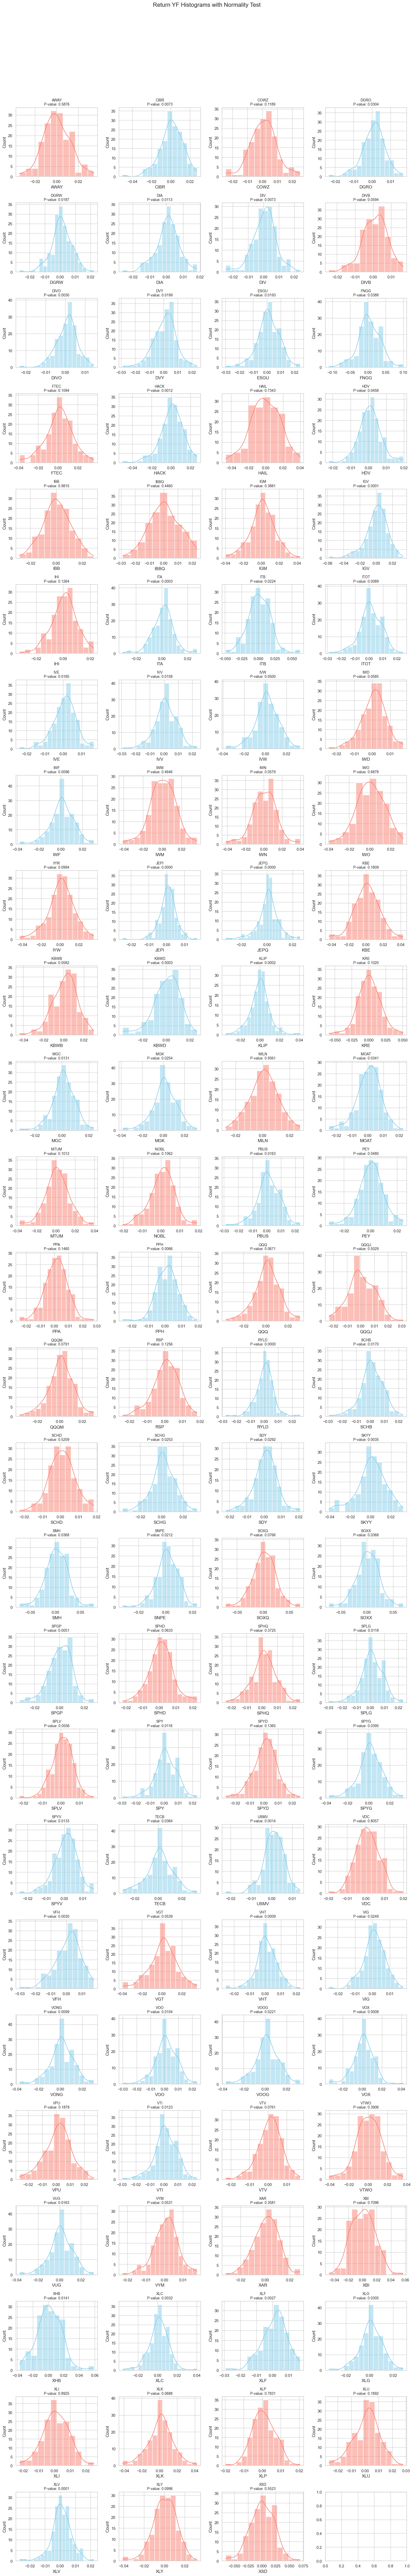

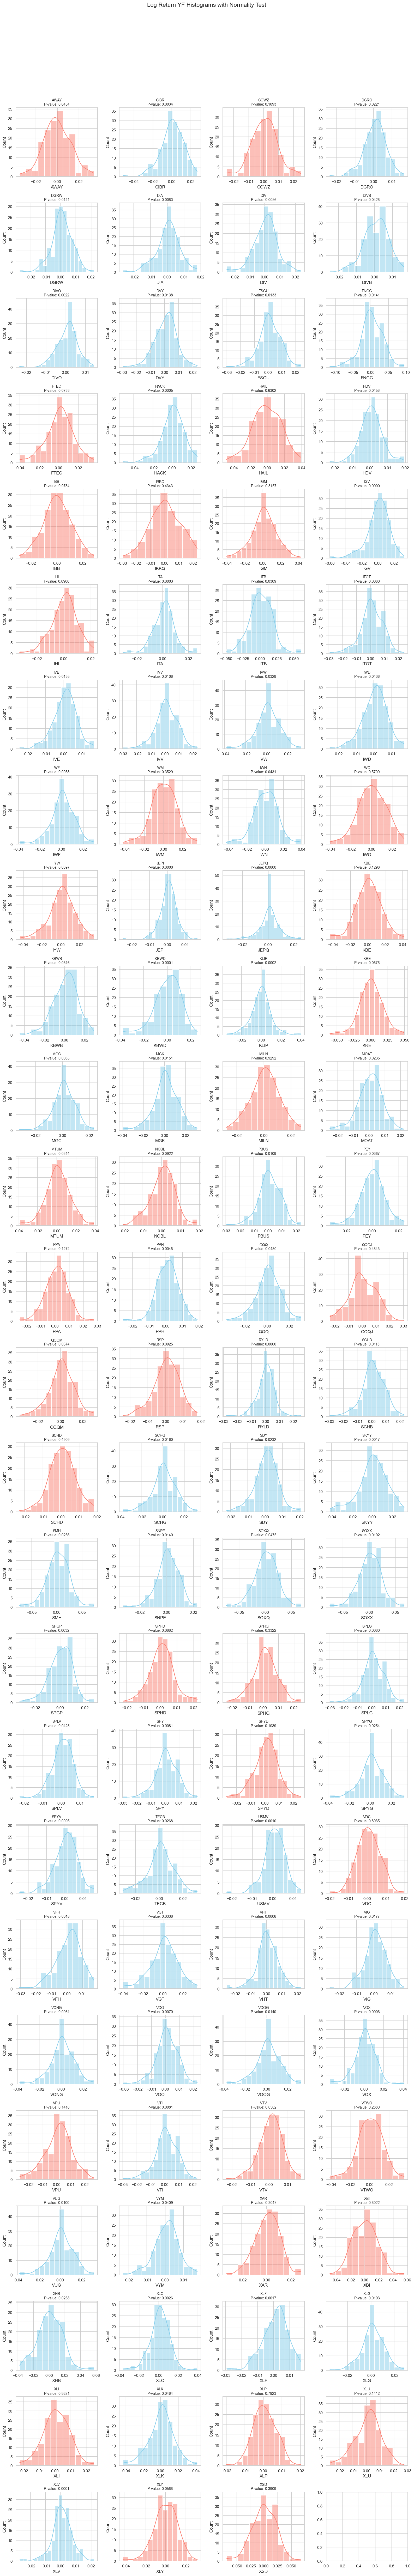

In [259]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import shapiro

# 히스토그램을 위한 서브플롯 생성 함수
def plot_histograms_with_pvalue(data, title, threshold=0.05):
    num_cols = len(data.columns)
    num_rows = int(np.ceil(num_cols / 4))
    fig, axes = plt.subplots(num_rows, 4, figsize=(16, 4 * num_rows))
    fig.suptitle(title, fontsize=16)

    for i, col in enumerate(data.columns):
        row, col_pos = divmod(i, 4)
        
        # 정규성 검정 수행
        stat, p_value = shapiro(data[col].dropna())
        
        # p-value에 따른 그래프 색상 설정
        color = "skyblue" if p_value < threshold else "salmon"
        sns.histplot(data[col].dropna(), kde=True, ax=axes[row, col_pos], color=color)
        
        # 그래프 제목에 p-value 표시
        axes[row, col_pos].set_title(f"{col}\nP-value: {p_value:.4f}", fontsize=10)
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 히스토그램 플롯
plot_histograms_with_pvalue(return_yf, "Return YF Histograms with Normality Test", threshold=0.05)
plot_histograms_with_pvalue(log_return_yf, "Log Return YF Histograms with Normality Test", threshold=0.05)

# 히트맵 생성 (값 표시 없이 색상만)


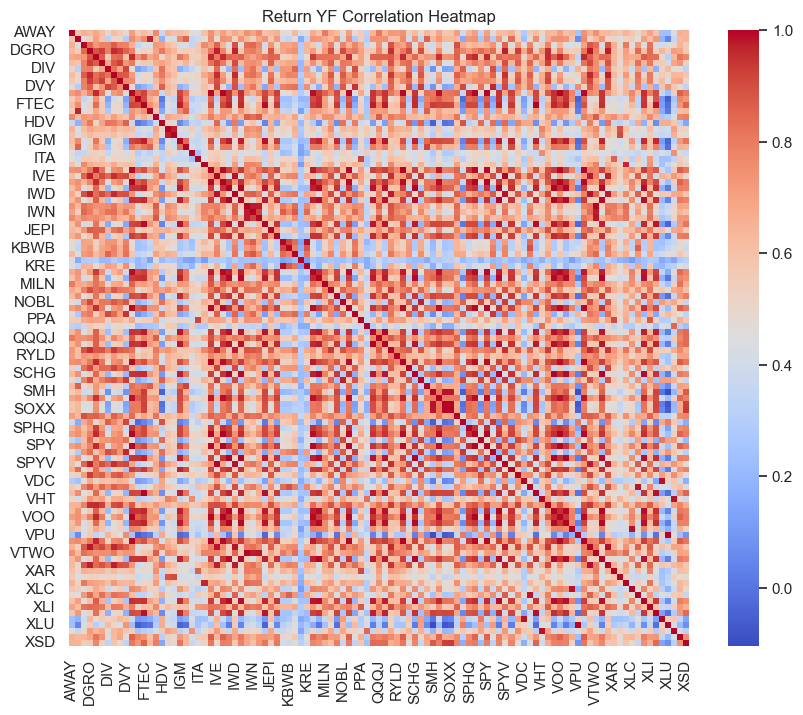

Return YF Statistics:
              AWAY        CIBR        COWZ        DGRO        DGRW         DIA  \
count  167.000000  167.000000  167.000000  167.000000  167.000000  167.000000   
mean     0.000106    0.000817    0.000700    0.000924    0.001009    0.000675   
std      0.012490    0.011932    0.008705    0.005989    0.006727    0.006837   
min     -0.034352   -0.050009   -0.024474   -0.023303   -0.026545   -0.025986   
25%     -0.008111   -0.005685   -0.004668   -0.002674   -0.002393   -0.002699   
50%     -0.000053    0.001052    0.000866    0.001270    0.001040    0.000933   
75%      0.008325    0.008971    0.005863    0.004415    0.004704    0.004680   
max      0.034430    0.027195    0.025156    0.016747    0.022140    0.018143   

              DIV        DIVB        DIVO         DVY  ...         XLC  \
count  167.000000  167.000000  167.000000  167.000000  ...  167.000000   
mean     0.000646    0.001016    0.000805    0.000872  ...    0.001218   
std      0.007540    0.00

In [261]:
plt.figure(figsize=(10, 8))
sns.heatmap(return_yf.corr(), cmap="coolwarm", cbar=True)
plt.title("Return YF Correlation Heatmap")
plt.show()

# 통계량 출력
print("Return YF Statistics:\n", return_yf.describe())
print("\nLog Return YF Statistics:\n", log_return_yf.describe())

많은 자산들이 상관관계를 가지고 있다.

## spillover 계산 엣지 계산

In [157]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from tqdm import tqdm

def compute_A_matrices(Phi_list, max_lags):
    N = Phi_list[0].shape[0]
    A_matrices = [np.eye(N)]  # A_0은 단위 행렬
    
    for i in range(1, max_lags + 1):
        A_i = np.zeros((N, N))
        for j in range(1, min(i, len(Phi_list)) + 1):
            A_i += Phi_list[j-1] @ A_matrices[i-j]
        A_matrices.append(A_i)
    
    return A_matrices

def kpps_fevd(results, A_matrices, H):
    sigma_u = results.sigma_u.to_numpy()  # 오차 공분산 행렬을 NumPy 배열로 변환
    n = sigma_u.shape[0]
    fevd_matrix = np.zeros((n, n, H))

    for h in range(H):
        for i in range(n):
            for j in range(n):
                numerator = 0
                denominator = 0
                for l in range(h + 1):
                    impact = A_matrices[l] @ sigma_u @ A_matrices[l].T
                    numerator += impact[i, j] ** 2
                    denominator += impact[i, i]
                fevd_matrix[i, j, h] = numerator / denominator if denominator != 0 else 0

    return fevd_matrix

def compute_spillover(group_data, window_size, horizon=5):
    spillover_matrices = []
    dates = []
    
    # PCA 적용이 필요한 경우 여기에 함수 정의 및 적용
    # group_data = apply_pca(group_data, variance_threshold=variance_threshold)
    
    # 날짜 기준으로 데이터프레임 정렬
    group_data = group_data.sort_index()
    
    # 롤링 윈도우를 사용하여 VAR 모델 적합
    for start in tqdm(range(len(group_data) - window_size + 1), desc="스필오버 매트릭스 계산 중"):
        end = start + window_size
        data_window = group_data.iloc[start:end]
        
        # Step 1: VAR 모델 적합
        model = VAR(data_window)
        try:
            results = model.fit(5)  # VAR(2) 모델; 필요에 따라 조정
        except np.linalg.LinAlgError:
            continue  # 모델 적합이 실패하면 해당 윈도우 건너뜀

        # Step 2: VAR 계수 추출
        Phi_list = [results.coefs[i] for i in range(results.k_ar)]
        
        # Step 3: A 매트릭스 계산
        A_matrices = compute_A_matrices(Phi_list, horizon)
        
        # Step 4: FEVD 매트릭스 계산
        gfevd_results = kpps_fevd(results, A_matrices, horizon)
        
        # Step 5: FEVD 정규화 (theta_tilde)
        theta_tilde = np.zeros_like(gfevd_results)
        for h in range(horizon):
            for i in range(gfevd_results.shape[0]):
                theta_sum = gfevd_results[i, :, h].sum()
                if theta_sum != 0:
                    theta_tilde[i, :, h] = gfevd_results[i, :, h] / theta_sum
        
        # Step 6: 원하는 지평선의 FEVD 선택
        selected_h = horizon - 1  # 0 기반 인덱스
        spillover_matrix = theta_tilde[:, :, selected_h]
        
        # Step 7: 스필오버 매트릭스를 pandas Series로 변환 (MultiIndex 사용)
        spillover_series = pd.Series(
            spillover_matrix.flatten(),
            index=pd.MultiIndex.from_product(
                [group_data.columns, group_data.columns],
                names=["From_ETF", "To_ETF"]
            )
        )
        
        # Step 8: 리스트에 추가
        spillover_matrices.append(spillover_series)
        dates.append(group_data.index[end-1])  # 윈도우의 마지막 날짜 저장
    
    # Step 9: 스필오버 매트릭스 리스트를 데이터프레임으로 변환
    spillover_df = pd.DataFrame(spillover_matrices, index=dates)
    spillover_long = spillover_df.stack(level=['From_ETF', 'To_ETF']).reset_index()
    spillover_long.columns = ['Time', 'From_ETF', 'To_ETF', 'Spillover_Value']
   
   
    
    return spillover_long


In [49]:
import warnings
#warnings.filterwarnings('default')
warnings.filterwarnings('ignore')

In [ ]:
spillover_long = compute_spillover(return_yf,window_size= 20, horizon = 5)

스필오버 매트릭스 계산 중: 100%|██████████| 128/128 [1:32:08<00:00, 43.19s/it]


In [52]:
volatility_ts = return_yf.rolling(window=20).std()
volatility_ts = volatility_ts.dropna()

In [441]:
spillover_long_vola = compute_spillover(volatility_ts,window_size= 20, horizon = 5)

스필오버 매트릭스 계산 중: 100%|██████████| 129/129 [1:00:21<00:00, 28.07s/it]


In [50]:
spillover_long_vola = pd.read_csv('spillover_long_vola.csv')

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# 서브플롯 설정
num_assets = volatility_ts.shape[1]
num_cols = 3  # 한 행에 3개의 그래프
num_rows = (num_assets + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 2.5 * num_rows), sharex=True, sharey=True)
axes = axes.flatten()

# 각 자산별로 변동성 시계열을 플롯
for i, asset in enumerate(volatility_ts.columns):
    ax = axes[i]
    asset_volatility = volatility_ts[asset].dropna()
    
    # 평균값, 전체 최대값, 최소값 계산
    mean_val = asset_volatility.mean()
    min_val = asset_volatility.min()
    max_val = asset_volatility.max()
    
    # 변동성 시계열 플롯
    ax.plot(asset_volatility.index, asset_volatility, color='b', label='Volatility')
    
    # 평균값과 범위 영역 추가
    ax.fill_between(asset_volatility.index, min_val, max_val, color='lightblue', alpha=0.3, label='Range')
    ax.axhline(mean_val, color='blue', linestyle='--', linewidth=1, label='Mean')
    
    # 제목과 스타일 설정
    ax.set_title(asset)
    ax.grid(True)
    ax.legend()

# 남은 빈 서브플롯 제거
for j in range(num_assets, len(axes)):
    fig.delaxes(axes[j])

# 전체 평균, 최대, 최소값의 시계열 계산
overall_mean = volatility_ts.mean(axis=1)
overall_min = volatility_ts.min(axis=1)
overall_max = volatility_ts.max(axis=1)

# 전체 시계열 평균, 최대, 최소값 플롯


NameError: name 'volatility_ts' is not defined

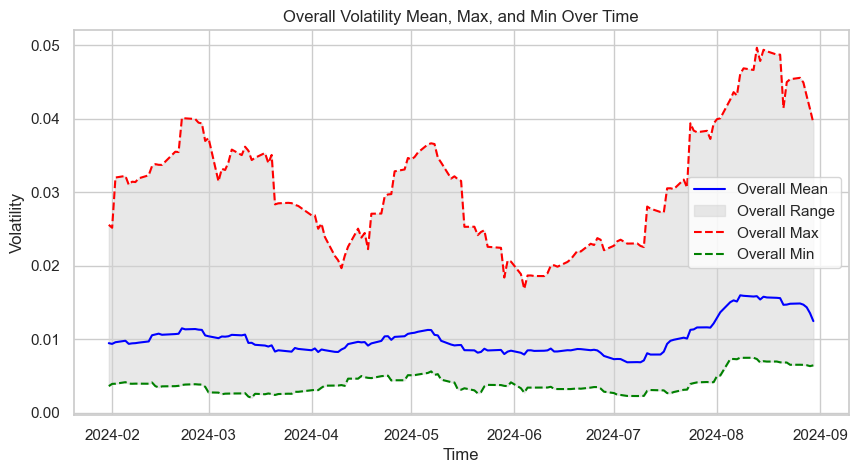

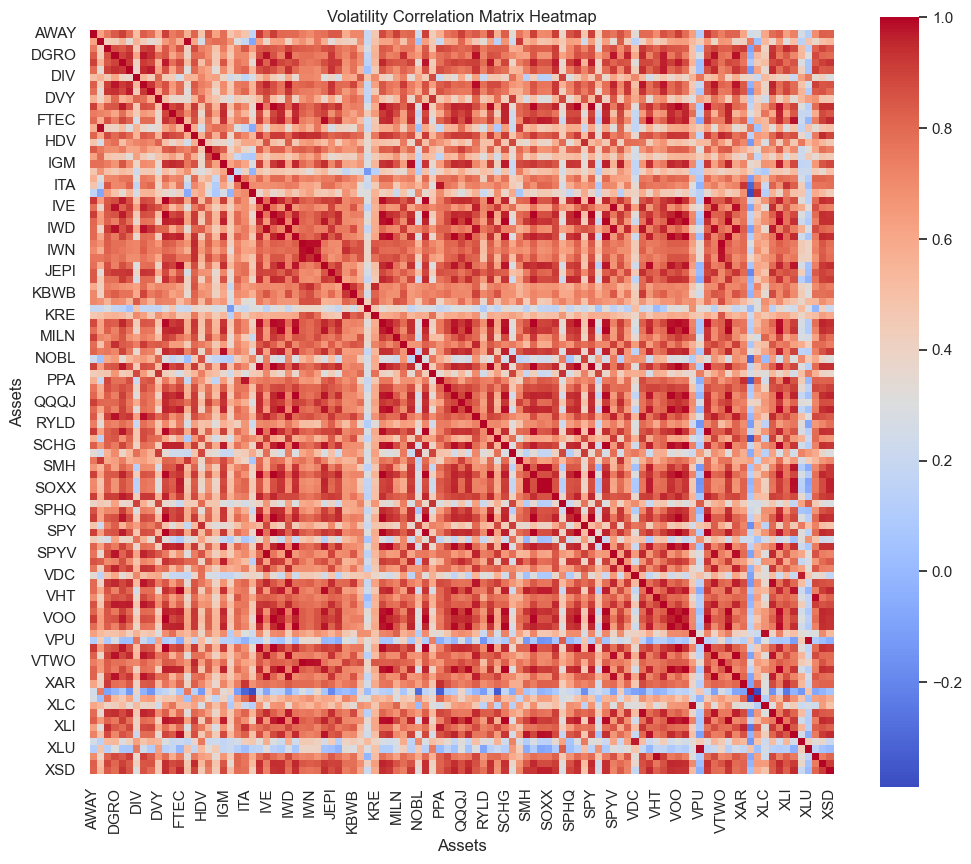

In [439]:
import matplotlib.pyplot as plt
import seaborn as sns

# 전체 평균, 최대, 최소값의 시계열 계산
overall_mean = volatility_ts.mean(axis=1)
overall_min = volatility_ts.min(axis=1)
overall_max = volatility_ts.max(axis=1)

# 전체 시계열 평균, 최대, 최소값 플롯
plt.figure(figsize=(10, 5))
plt.plot(overall_mean.index, overall_mean, label='Overall Mean', color='blue')
plt.fill_between(overall_mean.index, overall_min.values, overall_max.values, color='lightgrey', alpha=0.5, label='Overall Range')
plt.plot(overall_max.index, overall_max, label='Overall Max', color='red', linestyle='--')
plt.plot(overall_min.index, overall_min, label='Overall Min', color='green', linestyle='--')

plt.title("Overall Volatility Mean, Max, and Min Over Time")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()

correlation_matrix = volatility_ts.corr()

# 상관 관계 히트맵 생성
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', cbar=True, square=True, annot=False)
plt.title("Volatility Correlation Matrix Heatmap")
plt.xlabel("Assets")
plt.ylabel("Assets")
plt.show()

### 일정한 패턴이 보이는 것 같음

In [ ]:
# spillover_long.to_csv('spillover_long.csv')

In [443]:
spillover_long_vola.to_csv('spillover_long_vola.csv')

### spillover가 edge가 되기 충분한가?

In [53]:
filtered_df = spillover_long_vola[spillover_long_vola['To_ETF'] != spillover_long_vola['From_ETF']]

# Date와 To_ETF별로 그룹화하여 Spillover_Value 합계 계산
spillover_sum_by_date = filtered_df.groupby(['Time', 'From_ETF'])['Spillover_Value'].sum().reset_index()


In [54]:
spillover_sum_by_date

Time From_ETF  Spillover_Value
0      2024-02-28     AWAY         0.985446
1      2024-02-28     CIBR         0.952715
2      2024-02-28     COWZ         0.994119
3      2024-02-28     DGRO         0.997105
4      2024-02-28     DGRW         0.994502
...           ...      ...              ...
13282  2024-08-30      XLP         0.993313
13283  2024-08-30      XLU         0.993877
13284  2024-08-30      XLV         0.991580
13285  2024-08-30      XLY         0.981903
13286  2024-08-30      XSD         0.969725

[13287 rows x 3 columns]

In [55]:
total_vola_spillover = spillover_sum_by_date.groupby('Time')['Spillover_Value'].mean()

In [56]:
type(total_vola_spillover)


pandas.core.series.Series

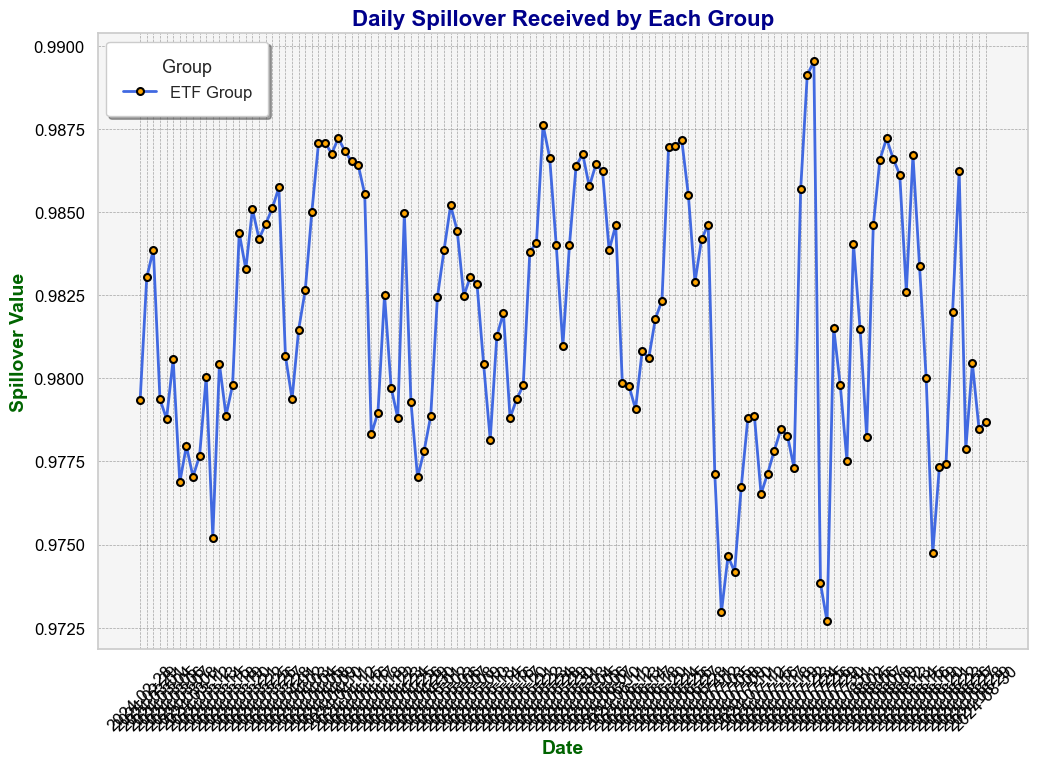

In [57]:
import matplotlib.pyplot as plt

# Plotting the spillover data with customized appearance
plt.figure(figsize=(12, 8))

# 주요 스타일 추가
plt.plot(total_vola_spillover, color='royalblue', linestyle='-', linewidth=2, marker='o', markersize=5, markerfacecolor='orange', markeredgewidth=1.5, markeredgecolor='black')

# Adding title and labels with customized fonts
plt.title("Daily Spillover Received by Each Group", fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=14, fontweight='bold', color='darkgreen')
plt.ylabel("Spillover Value", fontsize=14, fontweight='bold', color='darkgreen')

# Adding legend and customizing its position and appearance
plt.legend(["ETF Group"], loc='upper left', fontsize=12, title="Group", title_fontsize='13', fancybox=True, shadow=True, borderpad=1)

# Adding grid with a subtle line style
plt.grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.7)

# Customizing ticks and tick labels
plt.xticks(fontsize=12, rotation=45, color='black')
plt.yticks(fontsize=12, color='black')

# Adding background color to the plot area
plt.gca().set_facecolor('whitesmoke')

plt.show()

## egde

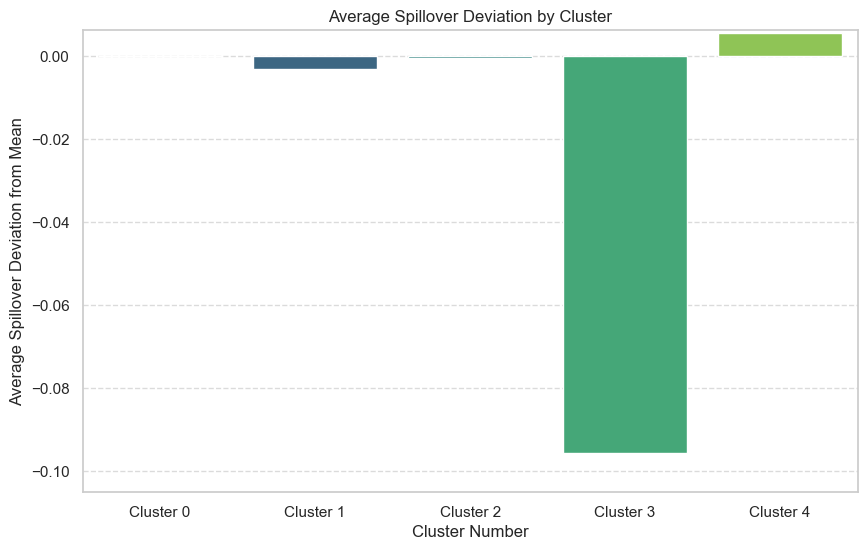

집단간의 유의미한 차이가 존재합니다.


In [ ]:

import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# Sample data to mimic user's data structure for testing
features_df = merged_df_cleaned

# Spillover 데이터
spillover_df  = spillover_sum_by_date

# Calculate the mean for feature columns and spillover values
feature_means = features_df[['TCO_AVG_EAL_PLS', 'TCO_AVG_PFT_RT', 'ACL_PFT_RT_Z_SOR', 'DIST_HNK_PCT10_NMV']].mean()
spillover_mean = spillover_df['Spillover_Value'].mean()

# Transform each ETF feature and spillover value to deviation from the mean
features_df[['TCO_AVG_EAL_PLS', 'TCO_AVG_PFT_RT', 'ACL_PFT_RT_Z_SOR', 'DIST_HNK_PCT10_NMV']] -= feature_means
spillover_df['Spillover_Value'] -= spillover_mean

# Perform K-Means clustering (k=5 for example)
kmeans = KMeans(n_clusters=5, random_state=42).fit(features_df[['TCO_AVG_EAL_PLS', 'TCO_AVG_PFT_RT', 'ACL_PFT_RT_Z_SOR', 'DIST_HNK_PCT10_NMV']])
features_df['Cluster'] = kmeans.labels_

# Merge features with spillover and calculate cluster means
merged_df = pd.merge(features_df, spillover_df, left_on='ETF_ID', right_on='From_ETF')
clustered_spillover = merged_df.groupby('Cluster')['Spillover_Value'].mean()

# Plotting the clustered spillover deviation from mean
plt.figure(figsize=(10, 6))
sns.barplot(x=clustered_spillover.index, y=clustered_spillover.values, palette="viridis")
plt.title("Average Spillover Deviation by Cluster")
plt.xlabel("Cluster Number")
plt.ylabel("Average Spillover Deviation from Mean")
plt.ylim(min(clustered_spillover.values) * 1.1, max(clustered_spillover.values) * 1.1)
plt.xticks(ticks=range(len(clustered_spillover)), labels=[f"Cluster {i}" for i in clustered_spillover.index])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ANOVA test between clusters
anova_data = [merged_df[merged_df['Cluster'] == cluster]['Spillover_Value'] for cluster in clustered_spillover.index]
anova_result = f_oneway(*anova_data)
if anova_result.pvalue < 0.05:
    print('집단간의 유의미한 차이가 존재합니다.')
else:
    print('집단간 차이가 존재하지 않습니다.')

특성 데이터를 통해 데이터를 군집화 하고 해당 군집에 속해있는 자산의 spillover값을 비교하였다.
각 군집에서 spillover값은 전체 데이터에서 상당히 이질적인 모습을 보였다. 즉, spillover가 노드의 특성을 잘 구분지을 수 있을 것이다. 

즉, spillover를 edge로 쓰겠다. 

## GNN 모델 구축

In [211]:
spillover_sum_by_date

Time From_ETF  Spillover_Value
0     2024-02-28     AWAY         0.985446
1     2024-02-28     CIBR         0.952715
2     2024-02-28     COWZ         0.994119
3     2024-02-28     DGRO         0.997105
4     2024-02-28     DGRW         0.994502
...          ...      ...              ...
13282 2024-08-30      XLP         0.993313
13283 2024-08-30      XLU         0.993877
13284 2024-08-30      XLV         0.991580
13285 2024-08-30      XLY         0.981903
13286 2024-08-30      XSD         0.969725

[13287 rows x 3 columns]

In [26]:
import pandas as pd

In [27]:
spillover_long_vola = pd.read_csv('spillover_long_vola.csv')

In [28]:
spillover_long_vola

Unnamed: 0        Time From_ETF To_ETF  Spillover_Value
0                 0  2024-02-28     AWAY   AWAY         0.014554
1                 1  2024-02-28     AWAY   CIBR         0.033023
2                 2  2024-02-28     AWAY   COWZ         0.005250
3                 3  2024-02-28     AWAY   DGRO         0.000601
4                 4  2024-02-28     AWAY   DGRW         0.004443
...             ...         ...      ...    ...              ...
1368556     1368556  2024-08-30      XSD    XLP         0.005661
1368557     1368557  2024-08-30      XSD    XLU         0.005570
1368558     1368558  2024-08-30      XSD    XLV         0.004189
1368559     1368559  2024-08-30      XSD    XLY         0.010919
1368560     1368560  2024-08-30      XSD    XSD         0.030275

[1368561 rows x 5 columns]

In [29]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [30]:
# merged_df = merged_df.fillna(method='backfill')

In [31]:
import torch
import pandas as pd
from torch_geometric.data import Data

# 재현성을 위해 시드 고정
np.random.seed(10)
torch.manual_seed(10)

def construct_temporal_graphs(spillover_df, etf_features_df):

    """
    스필오버 데이터와 ETF 특성 데이터를 기반으로 시변 그래프 데이터 리스트를 생성합니다.

    Parameters:
    - spillover_df (pd.DataFrame): 스필오버 데이터 (spillover_long).
    - etf_features_df (pd.DataFrame): ETF 특성 데이터 (merged_df_cleaned).

    Returns:
    - temporal_graphs (list of Data): 시변 그래프 데이터 리스트.
    """

    # 날짜 컬럼 이름 통일 ('Time'으로)
    spillover_df['Time'] = pd.to_datetime(spillover_df['Time'])
    etf_features_df['Time'] = pd.to_datetime(etf_features_df['BSE_DT'])

    # 공통된 날짜와 ETF ID 추출
    common_times = sorted(set(spillover_df['Time']) & set(etf_features_df['Time']))
    common_etf_ids = sorted(set(spillover_df['From_ETF']) & set(spillover_df['To_ETF']) & set(etf_features_df['ETF_ID']))

    # 공통 시간과 ETF ID로 데이터 필터링
    spillover_df = spillover_df[spillover_df['Time'].isin(common_times) & spillover_df['From_ETF'].isin(common_etf_ids) & spillover_df['To_ETF'].isin(common_etf_ids)]
    etf_features_df = etf_features_df[etf_features_df['Time'].isin(common_times) & etf_features_df['ETF_ID'].isin(common_etf_ids)]

    # 시간별로 ETF 특성 데이터 그룹화
    etf_features_grouped = etf_features_df.groupby('Time')
    spillover_grouped = spillover_df.groupby('Time')

    temporal_graphs = []

    # 공통 시간 리스트로 그래프 생성
    for time in common_times:
        # 해당 시간의 스필오버 데이터
        spillover_group = spillover_grouped.get_group(time)

        # 해당 시간의 ETF 특성 데이터
        etf_features_group = etf_features_grouped.get_group(time)

        # 시간별 ETF ID만으로 인덱스 생성
        etf_ids_time = etf_features_group['ETF_ID'].unique()
        etf_id_to_idx_time = {etf_id: idx for idx, etf_id in enumerate(etf_ids_time)}

        # 노드 특성 준비
        node_features_df = etf_features_group.set_index('ETF_ID').loc[etf_ids_time]
        node_features = torch.tensor(node_features_df.drop(columns=['Time', 'BSE_DT']).values, dtype=torch.float)

        # 노드 특성 정규화
        node_features = (node_features - node_features.mean(dim=0)) / node_features.std(dim=0)

        # 엣지와 가중치 추출
        from_nodes = spillover_group['From_ETF'].map(etf_id_to_idx_time).dropna().astype(int).values
        to_nodes = spillover_group['To_ETF'].map(etf_id_to_idx_time).dropna().astype(int).values

        edge_index = torch.tensor([from_nodes, to_nodes], dtype=torch.long)
        edge_attr = torch.tensor(spillover_group['Spillover_Value'].values, dtype=torch.float).unsqueeze(1)  # Feature 차원 추가

        # 그래프 데이터 생성
        data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
        temporal_graphs.append(data)

    return temporal_graphs

# 시변 그래프 데이터 생성
temporal_graphs = construct_temporal_graphs(spillover_long_vola, merged_df_cleaned)
print("\n시변 그래프 데이터 요약:")
print(f"시간 단계 수: {len(temporal_graphs)}")
print(f"노드 수 (첫 번째 시간 단계): {temporal_graphs[0].num_nodes}")
print(f"엣지 수 (첫 번째 시간 단계): {temporal_graphs[0].num_edges}")

/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_23804/189241575.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  etf_features_df['Time'] = pd.to_datetime(etf_features_df['BSE_DT'])



시변 그래프 데이터 요약:
시간 단계 수: 61
노드 수 (첫 번째 시간 단계): 103
엣지 수 (첫 번째 시간 단계): 10609


/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_23804/189241575.py:63: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  edge_index = torch.tensor([from_nodes, to_nodes], dtype=torch.long)


In [35]:
temporal_graphs

[Data(x=[103, 4], edge_index=[2, 10609], edge_attr=[10609, 1]),
 Data(x=[103, 4], edge_index=[2, 10609], edge_attr=[10609, 1]),
 Data(x=[103, 4], edge_index=[2, 10609], edge_attr=[10609, 1]),
 Data(x=[103, 4], edge_index=[2, 10609], edge_attr=[10609, 1]),
 Data(x=[103, 4], edge_index=[2, 10609], edge_attr=[10609, 1]),
 Data(x=[103, 4], edge_index=[2, 10609], edge_attr=[10609, 1]),
 Data(x=[103, 4], edge_index=[2, 10609], edge_attr=[10609, 1]),
 Data(x=[103, 4], edge_index=[2, 10609], edge_attr=[10609, 1]),
 Data(x=[103, 4], edge_index=[2, 10609], edge_attr=[10609, 1]),
 Data(x=[103, 4], edge_index=[2, 10609], edge_attr=[10609, 1]),
 Data(x=[103, 4], edge_index=[2, 10609], edge_attr=[10609, 1]),
 Data(x=[103, 4], edge_index=[2, 10609], edge_attr=[10609, 1]),
 Data(x=[103, 4], edge_index=[2, 10609], edge_attr=[10609, 1]),
 Data(x=[103, 4], edge_index=[2, 10609], edge_attr=[10609, 1]),
 Data(x=[103, 4], edge_index=[2, 10609], edge_attr=[10609, 1]),
 Data(x=[103, 4], edge_index=[2, 10609],

In [34]:
merged_df_cleaned

BSE_DT ETF_ID  TCO_AVG_EAL_PLS  TCO_AVG_PFT_RT  ACL_PFT_RT_Z_SOR  \
0    2024-05-28   AWAY       -215428.98          -13.96         54.725473   
1    2024-05-28   CIBR        330918.70           16.98         69.396940   
2    2024-05-28   COWZ        132543.21            6.11         61.926193   
3    2024-05-28   DGRO        563407.38           27.36         34.023402   
4    2024-05-28   DGRW        610295.67           31.05         53.285329   
...         ...    ...              ...             ...               ...   
6587 2024-08-27    XLP        333695.93           18.70         22.251082   
6588 2024-08-27    XLU        245469.13            9.52         47.619048   
6589 2024-08-27    XLV        505850.33           20.55         36.103896   
6590 2024-08-27    XLY        665956.71           17.02         19.740260   
6591 2024-08-27    XSD       1138035.05           35.30         27.878788   

      DIST_HNK_PCT10_NMV       Time  
0            27457.20000 2024-05-28  
1            53973.33333 2024-05-28  
2            57813.44118 2024-05-28  
3            50613.21182 2024-05-28  
4            60599.28571 2024-05-28  
...                  ...        ...  
6587         74936.50000 2024-08-27  
6588         81340.20000 2024-08-27  
6589        127515.00000 2024-08-27  
6590        176330.05882 2024-08-27  
6591        155445.70588 2024-08-27  

[6283 rows x 7 columns]

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# 모든 ETF에 대해 자기 자신에게 준 스필오버를 제외한 값을 계산
etf_list = spillover_long_vola['From_ETF'].unique()
spillover_timeseries = {}

for etf in etf_list:
    # 특정 ETF가 받는 스필오버 값 중 자기 자신에게 준 스필오버를 제외한 데이터 필터링
    etf_spillover = spillover_long[(spillover_long['From_ETF'] == etf) & (spillover_long['To_ETF'] != etf)]
    
    # 날짜별 스필오버 합계 계산
    etf_spillover_sum = etf_spillover.groupby('Time')['Spillover_Value'].sum()
    spillover_timeseries[etf] = etf_spillover_sum

# DataFrame 생성
spillover_df_timeseries = pd.DataFrame(spillover_timeseries)

# 서브플롯 설정
num_etfs = len(spillover_df_timeseries.columns)
num_cols = 4  # 한 행에 4개의 서브플롯
num_rows = (num_etfs + num_cols - 1) // num_cols  # 필요 행 수 계산

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 2.5 * num_rows), sharex=True, sharey=True)
axes = axes.flatten()

# 각 ETF별 시계열 데이터를 서브플롯으로 생성
for i, etf in enumerate(spillover_df_timeseries.columns):
    axes[i].plot(spillover_df_timeseries.index, spillover_df_timeseries[etf], label=etf, color="skyblue")
    axes[i].set_title(etf)
    axes[i].grid(True)
    axes[i].tick_params(axis='x', rotation=45)

# 빈 서브플롯 제거
for i in range(num_etfs, len(axes)):
    fig.delaxes(axes[i])

plt.suptitle("Spillover Received by Each ETF (Excluding Self-Spillover)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # 전체 레이아웃 설정
plt.show()

NameError: name 'spillover_long' is not defined


시변 그래프 신경망 모델 학습 중...
Epoch 1/300, Loss: 0.9859
Epoch 10/300, Loss: 0.9115
Epoch 20/300, Loss: 0.8715
Epoch 30/300, Loss: 0.8396
Epoch 40/300, Loss: 0.7511
Epoch 50/300, Loss: 0.7519
Epoch 60/300, Loss: 0.6121
Epoch 70/300, Loss: 0.5697
Epoch 80/300, Loss: 0.5904
Epoch 00082: reducing learning rate of group 0 to 5.0000e-04.
Epoch 90/300, Loss: 0.5079
Epoch 100/300, Loss: 0.4381
Epoch 110/300, Loss: 0.3896
Epoch 120/300, Loss: 0.3640
Epoch 130/300, Loss: 0.3463
Epoch 140/300, Loss: 0.5019
Epoch 00148: reducing learning rate of group 0 to 2.5000e-04.
Epoch 150/300, Loss: 0.4304
Epoch 00159: reducing learning rate of group 0 to 1.2500e-04.
Epoch 160/300, Loss: 0.4046
Epoch 00170: reducing learning rate of group 0 to 6.2500e-05.
Epoch 170/300, Loss: 0.3860
Epoch 180/300, Loss: 0.3703
Epoch 00181: reducing learning rate of group 0 to 3.1250e-05.
Epoch 190/300, Loss: 0.3624
Epoch 00192: reducing learning rate of group 0 to 1.5625e-05.
Epoch 200/300, Loss: 0.3586
Epoch 00203: reducing learni

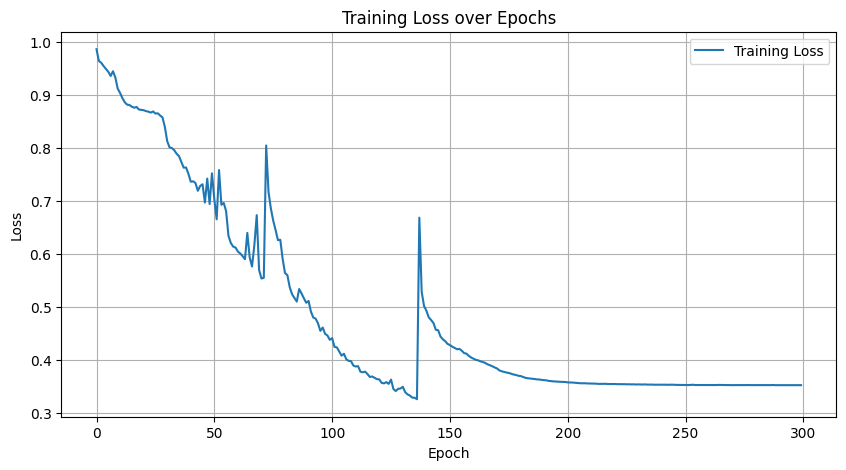

In [36]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau


# =========================
# 4. 모델 정의 및 학습 (오버피팅 방지 기법 추가)
# =========================

class TemporalGNN(nn.Module):
    def __init__(self, node_feature_size, hidden_size, embedding_size, dropout=0.3):
        super(TemporalGNN, self).__init__()
        
        # GCN 레이어
        self.gcn = GCNConv(node_feature_size, hidden_size)
        self.batch_norm = nn.BatchNorm1d(hidden_size)  # 배치 정규화
        
        # GRU 레이어
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        
        # 임베딩과 디코더 레이어
        self.embedding = nn.Linear(hidden_size, embedding_size)
        self.decoder = nn.Linear(embedding_size, node_feature_size)
        
        # 드롭아웃
        self.dropout = nn.Dropout(dropout)

    def forward(self, graph_sequence):
        hidden = None
        embeddings = []
        reconstructions = []
        
        for graph in graph_sequence:
            # GCN 레이어 및 드롭아웃, 배치 정규화
            x = self.gcn(graph.x, graph.edge_index)
            x = torch.relu(x)
            x = self.batch_norm(x)  # 배치 정규화
            x = self.dropout(x)  # 드롭아웃 적용
            
            # GRU를 통해 시퀀스 처리
            x = x.unsqueeze(0)  # 배치 차원 추가: (1, num_nodes, hidden_size)
            output, hidden = self.gru(x, hidden)
            output = output.squeeze(0)  # (num_nodes, hidden_size)
            
            # 임베딩 생성
            emb = self.embedding(output)
            embeddings.append(emb)
            
            # 노드 특성 재구성
            recon = self.decoder(emb)
            reconstructions.append(recon)
        
        return reconstructions, embeddings

def train_model(temporal_graphs, node_feature_size, hidden_size=64, embedding_size=64, learning_rate=0.001, epochs=300, patience=20):
    """
    시변 그래프 신경망 모델을 학습시킵니다.

    Parameters:
    - temporal_graphs (list of Data): 시변 그래프 데이터 리스트.
    - node_feature_size (int): 노드 특성의 크기.
    - hidden_size (int): 은닉층 크기.
    - embedding_size (int): 임베딩 크기.
    - learning_rate (float): 옵티마이저 학습률.
    - epochs (int): 학습 에폭 수.
    - patience (int): 조기 종료를 위한 에폭 수

    Returns:
    - model (TemporalGNN): 학습된 모델.
    - embeddings (torch.Tensor): 최종 노드 임베딩.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TemporalGNN(node_feature_size, hidden_size, embedding_size).to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5 ,verbose=True)
    criterion = nn.MSELoss()
    
    best_loss = float('inf')
    epochs_no_improve = 0
    loss_history = []

    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for t in range(len(temporal_graphs) - 1):
            graph_current = temporal_graphs[t].to(device)
            graph_next = temporal_graphs[t + 1].to(device)
            optimizer.zero_grad()
            
            # 현재 그래프로부터 재구성 및 임베딩
            recon, embeddings_batch = model([graph_current])
            recon = recon[0]  # 첫 번째 (유일한) 그래프의 재구성 결과
            
            # 목표값: 다음 시간 단계의 노드 특성
            target = graph_next.x
            
            # 손실 계산
            loss = criterion(recon, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # 평균 손실 기록
        avg_loss = total_loss / (len(temporal_graphs) - 1)
        loss_history.append(avg_loss)
        
        # 학습률 스케줄러에 현재 손실 전달
        scheduler.step(avg_loss)
        
        # 조기 종료 조건 확인
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # if epochs_no_improve >= patience:
        #     print(f"조기 종료: {epoch+1} 에폭에서 개선이 없으므로 학습을 종료합니다.")
        #     break
        
        # 10 에폭마다 손실 출력
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')
    
    # 학습 완료 후 마지막 시간 단계의 임베딩 추출
    model.eval()
    with torch.no_grad():
        recon, embeddings = model([temporal_graphs[-1].to(device)])
        embeddings = embeddings[0].cpu()
    
    return model, embeddings, loss_history

# 모델 학습
print("\n시변 그래프 신경망 모델 학습 중...")
model, embeddings, loss_history = train_model(
    temporal_graphs=temporal_graphs,
    node_feature_size=4,
    hidden_size=64,
    embedding_size=45,
    learning_rate=0.001,
    epochs=300,
 # 조기 종료를 위한 설정
)
print("모델 학습 완료.")

# 손실 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

In [38]:
import plotly.graph_objects as go
import networkx as nx

def visualize_graph_plotly(graph_data, etf_labels=None):
    """
    Plotly를 사용한 그래프 시각화 함수.

    Parameters:
    - graph_data (Data): GNN에서 사용된 그래프 데이터 (torch_geometric.data.Data 형식).
    - etf_labels (list of str): ETF 라벨 목록 (optional).
    """
    # NetworkX 그래프 생성
    G = nx.Graph()
    
    # 노드 추가
    num_nodes = graph_data.num_nodes
    for i in range(num_nodes):
        G.add_node(i)
    
    # 엣지 추가 (엣지 속성으로 가중치 추가)
    edge_index = graph_data.edge_index.cpu().numpy()
    edge_attr = graph_data.edge_attr.cpu().numpy().flatten()
    
    for i in range(edge_index.shape[1]):
        source = edge_index[0, i]
        target = edge_index[1, i]
        weight = edge_attr[i]
        G.add_edge(source, target, weight=weight)
    
    # 그래프 레이아웃 설정 (spring_layout은 노드 간의 힘 기반 레이아웃)
    pos = nx.spring_layout(G, seed=42)

    # Plotly를 위한 엣지 좌표 준비
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)  # 선의 끝을 표시하기 위한 None
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    # 노드 좌표 및 특성 준비
    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=etf_labels,
        textposition="top center",
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            size=20,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    # 그래프 그리기
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title='<br>Interactive Graph Visualization(Before learning)',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=0, l=0, r=0, t=40),
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False))
                    )
    fig.show()

# 그래프 시각화 예시 (첫 번째 시간 단계의 그래프를 사용)
etf_labels = merged_df_cleaned['ETF_ID'].tolist()  # ETF 라벨이 있다면 사용
visualize_graph_plotly(temporal_graphs[0], etf_labels)

In [39]:
import plotly.graph_objects as go
import networkx as nx

def visualize_learned_graph(graph_data, embeddings, etf_labels=None):
    """
    학습된 그래프의 노드 및 엣지 관계를 시각화하는 함수.

    Parameters:
    - graph_data (Data): GNN에서 사용된 그래프 데이터 (torch_geometric.data.Data 형식).
    - embeddings (torch.Tensor): 학습된 노드 임베딩 텐서.
    - etf_labels (list of str): ETF 라벨 목록 (optional).
    """
    # NetworkX 그래프 생성
    G = nx.Graph()
    
    # 노드 추가
    num_nodes = graph_data.num_nodes
    for i in range(num_nodes):
        G.add_node(i)
    
    # 엣지 추가 (엣지 속성으로 가중치 추가)
    edge_index = graph_data.edge_index.cpu().numpy()
    edge_attr = graph_data.edge_attr.cpu().numpy().flatten()
    
    for i in range(edge_index.shape[1]):
        source = edge_index[0, i]
        target = edge_index[1, i]
        weight = edge_attr[i]
        G.add_edge(source, target, weight=weight)
    
    # 그래프 레이아웃 설정 (임베딩을 레이아웃으로 사용)
    pos = {i: (embeddings[i, 0].item(), embeddings[i, 1].item()) for i in range(num_nodes)}

    # Plotly를 위한 엣지 좌표 준비
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)  # 선의 끝을 표시하기 위한 None
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    # 노드 좌표 및 특성 준비
    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=etf_labels,
        textposition="top center",
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            size=20,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    # 그래프 그리기
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title='<br>Learned Graph Visualization',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=0, l=0, r=0, t=40),
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False))
                    )
    fig.show()

# 학습된 그래프와 임베딩을 시각화
visualize_learned_graph(temporal_graphs[0], embeddings, etf_labels)

In [40]:

def cluster_embeddings(embeddings, num_clusters=5):
    """
    K-Means를 사용하여 ETF 임베딩을 클러스터링합니다.

    Parameters:
    - embeddings (torch.Tensor): 노드 임베딩.

    - num_clusters (int): 클러스터 수.

    Returns:
    - clusters (np.ndarray): 각 ETF의 클러스터 라벨.
    """
    embeddings_np = embeddings.numpy()
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    clusters = kmeans.fit_predict(embeddings_np)
    return clusters


In [41]:
df_all = pd.DataFrame()

In [42]:
num_clusters = 5
df_all = pd.DataFrame()
clusters = cluster_embeddings(embeddings, num_clusters=num_clusters)
df_all['ETF_ID'] = merged_df_cleaned['ETF_ID'].unique().copy()

df_all['Cluster'] = clusters


/Users/sonhyeongjin/miniforge3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [43]:
df_all['Cluster'].value_counts()

Cluster
4    31
0    24
1    19
3    18
2    11
Name: count, dtype: int64


클러스터 시각화 중...


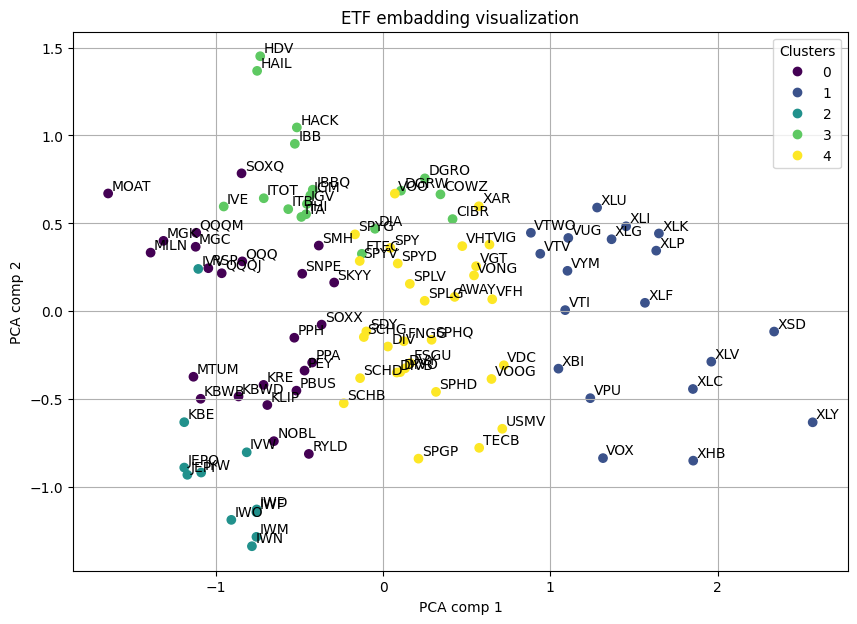

In [44]:
def visualize_clusters(embeddings, clusters, etf_features):
    """
    PCA를 사용하여 ETF 임베딩을 2차원으로 축소하고 클러스터를 시각화합니다.

    Parameters:
    - embeddings (torch.Tensor): 노드 임베딩.
    - clusters (np.ndarray): 클러스터 라벨.
    - etf_features (pd.DataFrame): ETF 특성 데이터프레임.
    """
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt

    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings.numpy())

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=clusters, cmap='viridis')

    for i, etf_id in enumerate(etf_features['ETF_ID']):
        plt.annotate(etf_id, (embeddings_2d[i,0]+0.02, embeddings_2d[i,1]+0.02))

    plt.title('ETF embadding visualization')
    plt.xlabel('PCA comp 1')
    plt.ylabel('PCA comp 2')
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.grid(True)
    plt.show()

# 클러스터 시각화
print("\n클러스터 시각화 중...")
visualize_clusters(embeddings, clusters, df_all)

## 노드 따라 진행하기

In [46]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.optim import Adam
import plotly.graph_objects as go
import torch.nn.functional as F
import networkx as nx
from torch_geometric.utils import to_networkx

# 재현성을 위해 시드 고정
np.random.seed(10)
torch.manual_seed(10)

# ... [데이터 준비 및 모델 정의 코드는 생략되었습니다] ...

# [생략된 데이터 준비 및 모델 학습 코드]

# 1. 출력 임베딩값으로 그래프 다시 만들기
def create_graph_from_embeddings(embeddings, threshold=0.7):
    embeddings_norm = F.normalize(embeddings, p=2, dim=1)
    similarity_matrix = torch.mm(embeddings_norm, embeddings_norm.t())
    adjacency_matrix = (similarity_matrix > threshold).float()
    adjacency_matrix.fill_diagonal_(0)
    new_edge_index = adjacency_matrix.nonzero(as_tuple=False).t().contiguous()
    return new_edge_index

new_edge_index = create_graph_from_embeddings(embeddings, threshold=0.7)
new_data = Data(x=temporal_graphs[-1].x, edge_index=new_edge_index)

In [58]:
import plotly.express as px
etf_id_to_cluster = dict(zip(df_all['ETF_ID'], df_all['Cluster']))
node_clusters = [etf_id_to_cluster[label] for label in etf_labels]
# 고유한 클러스터 수 확인
num_clusters = df_all['Cluster'].nunique()

# Plotly의 색상 팔레트 사용
color_scale = px.colors.qualitative.Plotly  # 또는 다른 팔레트 사용 가능
cluster_colors = color_scale * (num_clusters // len(color_scale) + 1)  # 색상 반복

# 클러스터 번호를 색상으로 매핑
cluster_to_color = {cluster: cluster_colors[i] for i, cluster in enumerate(sorted(df_all['Cluster'].unique()))}

# 노드 색상 리스트 생성
node_colors = [cluster_to_color[cluster] for cluster in node_clusters]

In [59]:
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go

# 1. 임베딩과 엣지 데이터 준비
# embeddings: (노드 수, 임베딩 차원)의 NumPy 배열
# edge_index: (2, 엣지 수)의 PyTorch Tensor

# 예시로 embeddings와 edge_index를 생성합니다. 실제 데이터로 대체하세요.
# embeddings = np.random.rand(노드_수, 임베딩_차원)
# edge_index = torch.tensor([[...], [...]])

# edge_index를 NumPy 배열로 변환하고 인덱스 조정
edge_index_np = new_edge_index.numpy() - 1  # 인덱스가 1부터 시작하면 1을 빼줍니다
edges = list(zip(edge_index_np[0], edge_index_np[1]))

# 2. 임베딩을 3차원으로 축소
reducer = umap.UMAP(n_components=3)
embeddings_3d = reducer.fit_transform(embeddings)

# 3. Plotly를 사용하여 그래프 시각화

node_labels = df_all['ETF_ID']
edge_trace = []
for edge in edges:
    start, end = edge
    x_coords = [embeddings_3d[start, 0], embeddings_3d[end, 0], None]
    y_coords = [embeddings_3d[start, 1], embeddings_3d[end, 1], None]
    z_coords = [embeddings_3d[start, 2], embeddings_3d[end, 2], None]
    edge_trace.append(go.Scatter3d(
        x=x_coords, y=y_coords, z=z_coords,
        mode='lines',
        line=dict(color='gray', width=1),
        hoverinfo='none'
    ))

# 노드 트레이스 생성 (색상 적용)
node_trace = go.Scatter3d(
    x=embeddings_3d[:, 0],
    y=embeddings_3d[:, 1],
    z=embeddings_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=node_colors,  # 클러스터에 따른 색상 적용
    ),
    text=node_labels,  # 호버 정보로 ETF_ID 표시
    hoverinfo='text',
)

fig = go.Figure(data=edge_trace + [node_trace])

fig.update_layout(
    title='인터랙티브 3D 그래프 시각화 (클러스터별 색상 적용)',
    showlegend=False,
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    )
)

fig.show()

-----

## 군집별 수익률

In [60]:
etf_return = OHLCV[OHLCV['TCK_IEM_CD'].isin(score_etf)].pivot(index='BSE_DT',columns='TCK_IEM_CD',values='BF_DD_CMP_IND_RT')*0.01

In [61]:
etf_return

TCK_IEM_CD    AIYY    AMZY    APLY    AWAY    CIBR    COWZ    DGRO    DGRW  \
BSE_DT                                                                       
20240528    0.0000  0.0106 -0.0052 -0.0045 -0.0133 -0.0016 -0.0071 -0.0026   
20240529   -0.0105  0.0000  0.0017 -0.0087 -0.0075 -0.0095 -0.0103 -0.0087   
20240530    0.1400 -0.0131  0.0115  0.0084 -0.0244  0.0132  0.0034 -0.0005   
20240531    0.0216 -0.0163 -0.0028  0.0030  0.0021  0.0187  0.0137  0.0104   
20240603    0.0038  0.0085  0.0057  0.0020 -0.0103 -0.0130 -0.0045 -0.0021   
...            ...     ...     ...     ...     ...     ...     ...     ...   
20240820   -0.0240  0.0036  0.0062 -0.0165  0.0072 -0.0090 -0.0025 -0.0002   
20240821    0.0118  0.0082 -0.0022  0.0163  0.0032  0.0114  0.0040  0.0044   
20240822   -0.0282 -0.0188 -0.0050 -0.0165 -0.0118 -0.0034 -0.0016 -0.0058   
20240823    0.0160  0.0036  0.0090  0.0255  0.0123  0.0215  0.0094  0.0101   
20240826    0.0000 -0.0041  0.0050 -0.0079 -0.0068  0.0002  0.0013 -0.0012   

TCK_IEM_CD     DIA     DIV  ...     XLF     XLG     XLI     XLK     XLP  \
BSE_DT                      ...                                           
20240528   -0.0052 -0.0017  ... -0.0111  0.0074 -0.0122  0.0042 -0.0078   
20240529   -0.0103 -0.0110  ... -0.0080 -0.0052 -0.0142 -0.0063 -0.0072   
20240530   -0.0081  0.0111  ...  0.0054 -0.0126  0.0068 -0.0228  0.0026   
20240531    0.0159  0.0174  ...  0.0146  0.0046  0.0121  0.0016  0.0156   
20240603   -0.0033  0.0023  ... -0.0062  0.0069 -0.0122  0.0025 -0.0004   
...            ...     ...  ...     ...     ...     ...     ...     ...   
20240820   -0.0013 -0.0033  ... -0.0032 -0.0002 -0.0027 -0.0035  0.0050   
20240821    0.0011  0.0067  ... -0.0016  0.0019  0.0060  0.0059  0.0068   
20240822   -0.0037 -0.0028  ...  0.0057 -0.0118 -0.0012 -0.0230 -0.0015   
20240823    0.0107  0.0133  ...  0.0086  0.0113  0.0100  0.0162  0.0028   
20240826    0.0022  0.0044  ...  0.0032 -0.0036 -0.0011 -0.0125  0.0071   

TCK_IEM_CD     XLU     XLV     XLY     XSD    YMAG  
BSE_DT                                              
20240528   -0.0010 -0.0121 -0.0024  0.0137 -0.0010  
20240529   -0.0129 -0.0078 -0.0066 -0.0189  0.0035  
20240530    0.0135  0.0005  0.0059  0.0049 -0.0098  
20240531    0.0176  0.0146  0.0056  0.0004 -0.0025  
20240603   -0.0114  0.0070 -0.0005 -0.0006  0.0074  
...            ...     ...     ...     ...     ...  
20240820   -0.0021  0.0040 -0.0009 -0.0092  0.0016  
20240821    0.0071  0.0017  0.0126  0.0225  0.0052  
20240822   -0.0012  0.0006 -0.0173 -0.0295 -0.0192  
20240823    0.0028  0.0043  0.0193  0.0335  0.0132  
20240826    0.0065 -0.0005 -0.0078 -0.0177 -0.0057  

[63 rows x 117 columns]

In [62]:
# 빈 딕셔너리 생성

cluster_dict = {}
def add_value(key, value):
    if key in cluster_dict:
        cluster_dict[key].append(value)
    else:
        cluster_dict[key] = [value]

# 값 추가 예시


In [63]:

for i in df_all[['ETF_ID', 'Cluster']].iterrows():
    add_value(i[1][1],etf_return[i[1][0]].values)

/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_23804/408120673.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [64]:
cluster_0_return  = pd.DataFrame(cluster_dict[0]).T
cluster_1_return = pd.DataFrame(cluster_dict[1]).T
cluster_2_return = pd.DataFrame(cluster_dict[2]).T
cluster_3_return = pd.DataFrame(cluster_dict[3]).T
cluster_4_return = pd.DataFrame(cluster_dict[4]).T



In [65]:
cluster_1_return

0       1       2       3       4       5       6       7       8   \
0   0.0020 -0.0017  0.0000 -0.0071 -0.0011  0.0054 -0.0057  0.0034 -0.0141   
1  -0.0053 -0.0124 -0.0082 -0.0105 -0.0147 -0.0036 -0.0109 -0.0185 -0.0146   
2  -0.0040  0.0125 -0.0049  0.0043  0.0093 -0.0145  0.0057  0.0169  0.0172   
3   0.0096  0.0185  0.0077  0.0155  0.0078 -0.0008  0.0163  0.0019  0.0133   
4   0.0046 -0.0098  0.0003 -0.0056 -0.0049  0.0077 -0.0073  0.0257 -0.0119   
..     ...     ...     ...     ...     ...     ...     ...     ...     ...   
58 -0.0004 -0.0024 -0.0024 -0.0029 -0.0113 -0.0010 -0.0051 -0.0002 -0.0066   
59  0.0045  0.0072  0.0050  0.0038  0.0124  0.0047  0.0046  0.0098  0.0290   
60 -0.0082 -0.0015 -0.0085 -0.0018 -0.0085 -0.0147 -0.0022 -0.0165 -0.0041   
61  0.0087  0.0032  0.0127  0.0111  0.0313  0.0115  0.0126  0.0137  0.0429   
62 -0.0007  0.0055 -0.0025  0.0012  0.0008 -0.0058  0.0014  0.0019 -0.0095   

        9       10      11      12      13      14      15      16      17  \
0   0.0017 -0.0111  0.0074 -0.0122  0.0042 -0.0078 -0.0010 -0.0121 -0.0024   
1  -0.0053 -0.0080 -0.0052 -0.0142 -0.0063 -0.0072 -0.0129 -0.0078 -0.0066   
2  -0.0033  0.0054 -0.0126  0.0068 -0.0228  0.0026  0.0135  0.0005  0.0059   
3   0.0107  0.0146  0.0046  0.0121  0.0016  0.0156  0.0176  0.0146  0.0056   
4   0.0040 -0.0062  0.0069 -0.0122  0.0025 -0.0004 -0.0114  0.0070 -0.0005   
..     ...     ...     ...     ...     ...     ...     ...     ...     ...   
58 -0.0007 -0.0032 -0.0002 -0.0027 -0.0035  0.0050 -0.0021  0.0040 -0.0009   
59  0.0042 -0.0016  0.0019  0.0060  0.0059  0.0068  0.0071  0.0017  0.0126   
60 -0.0075  0.0057 -0.0118 -0.0012 -0.0230 -0.0015 -0.0012  0.0006 -0.0173   
61  0.0070  0.0086  0.0113  0.0100  0.0162  0.0028  0.0028  0.0043  0.0193   
62  0.0023  0.0032 -0.0036 -0.0011 -0.0125  0.0071  0.0065 -0.0005 -0.0078   

        18  
0   0.0137  
1  -0.0189  
2   0.0049  
3   0.0004  
4  -0.0006  
..     ...  
58 -0.0092  
59  0.0225  
60 -0.0295  
61  0.0335  
62 -0.0177  

[63 rows x 19 columns]

In [66]:
from scipy import stats
def df_ANONVA(cluster_return):
    group_data = [cluster_return[col].dropna() for col in cluster_return.columns]
    group_names = cluster_return.columns.tolist()
    # ANOVA 검정 수행
   
    if len(group_data) != 1:
        f_stat, p_value = stats.f_oneway(*group_data)

        print('ANOVA 검정 결과:')
        print(f'F-통계량: {f_stat:.4f}, p-값: {p_value:.4f}')

        # 결과 해석
        if p_value < 0.05:
            print('그룹 간 평균에 유의한 차이가 있습니다.')
        else:
            print('그룹 간 평균에 유의한 차이가 없습니다.')
    else:
        pass

In [67]:
df_ANONVA(cluster_0_return)
df_ANONVA(cluster_1_return)
df_ANONVA(cluster_2_return)
df_ANONVA(cluster_3_return)
df_ANONVA(cluster_4_return)



ANOVA 검정 결과:
F-통계량: 0.1881, p-값: 1.0000
그룹 간 평균에 유의한 차이가 없습니다.
ANOVA 검정 결과:
F-통계량: 0.1081, p-값: 1.0000
그룹 간 평균에 유의한 차이가 없습니다.
ANOVA 검정 결과:
F-통계량: 0.1255, p-값: 0.9995
그룹 간 평균에 유의한 차이가 없습니다.
ANOVA 검정 결과:
F-통계량: 0.2103, p-값: 0.9998
그룹 간 평균에 유의한 차이가 없습니다.
ANOVA 검정 결과:
F-통계량: 0.0938, p-값: 1.0000
그룹 간 평균에 유의한 차이가 없습니다.


각각의 그룹내에서 차이가 존재하지 않았음 즉, 잘 묶어졌음을 확인할 수 있다!

## ETF 묶음으로 새로운 테마를 만든다

클러스터링 된 그룹은 투자자들에게 와닿지 않을 수 있다. 그렇기에 해당 테마에 존재하는 종목의 정보(일단은 이름)를 통해 gpt 4o에게 테마의 이름을 짓게 만든다

In [ ]:
import pandas as pd
import random
import openai
import os
from typing import List

In [ ]:
import pandas as pd

def create_cluster_groups(df: pd.DataFrame):
    """
    DataFrame을 클러스터별로 그룹화하여 리스트로 반환합니다.
    
    Args:
        df (pd.DataFrame): ETF 데이터가 포함된 DataFrame. 'ETF_ID'와 'Cluster' 컬럼을 포함.
    
    Returns:
        List[pd.DataFrame]: 클러스터별 ETF 그룹을 포함하는 DataFrame 리스트.
    """
    # 'Cluster' 컬럼이 존재하는지 확인
    if 'Cluster' not in df.columns:
        raise ValueError("DataFrame에 'Cluster' 컬럼이 존재하지 않습니다.")
    
    # 'Cluster' 컬럼의 결측값(NaN) 처리
    if df['Cluster'].isnull().any():
        print("경고: 일부 ETF의 'Cluster' 값이 NaN입니다. 해당 ETF는 제외됩니다.")
        df = df.dropna(subset=['Cluster'])
    
    # 'Cluster' 컬럼을 정수형으로 변환 (필요 시)
    df['Cluster'] = df['Cluster'].astype(int)
    
    # 클러스터별로 그룹화
    grouped = df.groupby('Cluster')
    
    # 각 클러스터 그룹을 DataFrame 리스트로 변환
    cluster_groups = [group.reset_index(drop=True) for _, group in grouped]
    
    return cluster_groups

# 사용 예시
if __name__ == "__main__":


    
    # 클러스터별 그룹 생성
    cluster_groups = create_cluster_groups(etf_features_1)
    
    # 결과 출력


In [ ]:
cluster_groups[4]

index ETF_ID  CRR_Z_SOR  DIST_HNK_PCT70_NMV  DIST_HNK_PCT10_NMV  \
0   DIA    DIV   0.517443            1.408337            1.584243   
1   IVV   JEPQ  -0.385302            2.691592            2.685728   
2   QQQ    SPY  -1.056499            2.024617            1.897325   
3   SPY   DIVO  -0.255272            2.729419            2.817187   
4   VOO   SCHD  -0.316622            2.646264            2.750535   

   ACL_PFT_RT_Z_SOR  IFO_RT_Z_SOR  DIST_HNK_PCT30_NMV  MXDD_Z_SOR  Cluster  
0         -0.074762     -0.231060            1.713689    1.531970        4  
1          0.863928      0.859745            2.731690    0.866478        4  
2          1.216051      1.200238            1.978466    0.144481        4  
3          0.858245      0.853039            2.779721    0.927539        4  
4          0.859766      0.855206            2.597198    0.903805        4

In [ ]:
etf_descriptions.head()

FC_SEC_KRL_NM TCK_IEM_CD
6     GraniteShares 1.75x Long AAPL Daily ETF       AAPB
8      Direxion Daily AAPL Bull 2X Shares ETF       AAPU
81   Simplify Aggregate Bond Credit Hedge ETF       AGGH
96                        iShares Asia 50 ETF        AIA
101   Global X Artificial Intellig & Tech ETF        AIQ

In [ ]:
question_list = []
for i in cluster_groups:
    question_str = "The name of the ETFs in my theme is as follows. "
    des_arry = etf_descriptions[etf_descriptions['TCK_IEM_CD'].isin(i['ETF_ID'].values)]['FC_SEC_KRL_NM'].values
    for j in des_arry:
        question_str += j 
        question_str += '. '
    question_str += ' Please name this theme. The answer is just the name of the theme.'
    question_list.append(question_str)

In [ ]:
question_list

['The name of the ETFs in my theme is as follows. WisdomTree US Quality Div Growth ETF. iShares US Medical Devices ETF. VanEck Morningstar Wide Moat ETF. ProShares S&P 500 Divi Aristocrats ETF. Invesco QQQ Trust Series 1 ETF. Invesco NASDAQ 100 ETF. Vanguard Dividend Appreciation Index ETF. Vanguard High Dividend Yield ETF.  Please name this theme. The answer is just the name of the theme.',
 'The name of the ETFs in my theme is as follows. ETFMG Travel Tech ETF. iShares S&P 500 ETF. iShares Russell 2000 ETF. KranceShrs Chn Intrnt Cvrd Cll Stgy ETF. Global X Russell 2000 Covered Call ETF. iShares Semiconductor ETF. SPDR Portfolio S&P 500 ETF. VANGUARD S&P 500 ETF.  Please name this theme. The answer is just the name of the theme.',
 'The name of the ETFs in my theme is as follows. First Trust NASDAQ Cybersecurity ETF. iShares Core Dividend Growth ETF. SPDR Dow Industrial Average Trust ETF. JPMorgan Equity Premium INCO ETF. Vanguard Mega Cap Growth Index ETF. First Trust Cloud Computing

In [ ]:
import openai
import os


openai.api_key="your_api"

def get_chatgpt_response(prompt):
    try:
        response = openai.ChatCompletion.create(
            model="gpt-4o",
            messages=[
                {"role": "user", "content": prompt}
            ]
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"오류 발생: {str(e)}"
answer_list = []
if __name__ == "__main__":
    for i in question_list:
        
        answer = get_chatgpt_response(i)
        answer_list.append(answer)


In [ ]:
answer_list

['오류 발생: Incorrect API key provided: your_api. You can find your API key at https://platform.openai.com/account/api-keys.',
 '오류 발생: Incorrect API key provided: your_api. You can find your API key at https://platform.openai.com/account/api-keys.',
 '오류 발생: Incorrect API key provided: your_api. You can find your API key at https://platform.openai.com/account/api-keys.',
 '오류 발생: Incorrect API key provided: your_api. You can find your API key at https://platform.openai.com/account/api-keys.',
 '오류 발생: Incorrect API key provided: your_api. You can find your API key at https://platform.openai.com/account/api-keys.']

---

### 결론
- 기존의 ETF테마가 시장의 변화를 잘 반영하지 못하는 문제가 있었습니다.

- 투자 고수 집단의 경우 시장 상황에 맞춰 발빠른 대응을 하였지만 일반 투자자들의 경우 시장 상황에 따라 판단을 빠르게 하는것이 쉽지 않기 때문에 좋은 테마를 택해 장기적인 운용을 하는 것이 중요합니다.

- 따라서 계층적 학습을 통해 시장 변화를 반영하기 좋은 특성을 선택하여 고차원 데이터를 GNN을 통해 학습을 진행하였습니다.

 - 최종적으로 학습된 결과를 사용자가 이해하고 사용하기 쉽게 하기위해 3차원으로 시각화를 하고 사용자가 주목해야할 ETF를 직관적으로 파악할 수 있게 제공하여 분산투자를 할 수 있게 유도합니다.